In [1]:
import os

import numpy as np
import scipy as sp
from scipy import stats
from matplotlib import pyplot as plt

from sklearn import linear_model
from sklearn.linear_model import LinearRegression as linreg
from sklearn.linear_model import HuberRegressor as hubreg


import TwoPUtils

%load_ext autoreload
%autoreload 2

In [2]:
basedir_VR = '/home/mplitt/VR_scratch'
figdir_local = '/home/mplitt/Fig_scratch'
figdir_remote = '/STX3_2P_results/scratch'

In [5]:
def get_block_number(sess):
    tport_times = sess.vr_data['time'].iloc[sess.teleport_inds]._values
    tstart_times = sess.vr_data['time'].iloc[sess.trial_start_inds]._values
    ITI = tstart_times[1:]-tport_times[:-1]
    block_number_trial = np.zeros(tport_times.shape)
    block_number_counter = 0
    
    
    block_number_time = np.zeros(sess.vr_data.shape[0])
    for i in range(1,tport_times.shape[-1]):
        if ITI[i-1]>60:
            block_number_counter+=1
            block_number_time[sess.teleport_inds[i-1]+1]=1
        block_number_trial[i] = block_number_counter
    
   
    return block_number_trial, np.cumsum(block_number_time)

def get_LR_trial(sess):
    lr_trial = np.zeros(sess.teleport_inds.shape)
    for i, (start,stop) in enumerate(zip(sess.trial_start_inds.tolist(),sess.teleport_inds.tolist())):
        lr_trial[i] = sess.vr_data['LR'].iloc[start+1 ]
    return lr_trial


In [6]:
KOs = {'4467975.1': (({'date': '28_09_2020', 'scene':'YMaze_LNovel','session':1},{'date': '28_09_2020', 'scene':'YMaze_LNovel','session':6}), ##########################
                     ({'date': '29_09_2020', 'scene':'YMaze_LNovel','session':1},),
                     ({'date': '30_09_2020', 'scene':'YMaze_LNovel','session':1},),
                     ({'date': '01_10_2020', 'scene':'YMaze_LNovel','session':1},),
                     ({'date': '02_10_2020', 'scene':'YMaze_LNovel','session':1},),
                     ({'date': '03_10_2020', 'scene':'YMaze_LNovel','session':1},)),
       '4467975.2': (({'date': '28_09_2020', 'scene':'YMaze_LNovel','session':3},), ##########################
                     ({'date': '29_09_2020', 'scene':'YMaze_LNovel','session':1},),
                     ({'date': '30_09_2020', 'scene':'YMaze_LNovel','session':1},),
                     ({'date': '01_10_2020', 'scene':'YMaze_LNovel','session':1},),
                     ({'date': '02_10_2020', 'scene':'YMaze_LNovel','session':1},),
                     ({'date': '03_10_2020', 'scene':'YMaze_LNovel','session':1},)),
       '4467975.3': (({'date': '28_09_2020', 'scene':'YMaze_LNovel','session':1},), #######################
                     ({'date': '29_09_2020', 'scene':'YMaze_LNovel','session':1},),
                     ({'date': '30_09_2020', 'scene':'YMaze_LNovel','session':2},),
                     ({'date': '01_10_2020', 'scene':'YMaze_LNovel','session':1},),
                     ({'date': '02_10_2020', 'scene':'YMaze_LNovel','session':1},),
                     ({'date': '03_10_2020', 'scene':'YMaze_LNovel','session':1},)),
       '4467975.4': (({'date': '28_09_2020', 'scene':'YMaze_LNovel','session':1},), ############################
                     ({'date': '29_09_2020', 'scene':'YMaze_LNovel','session':1},),
                     ({'date': '30_09_2020', 'scene':'YMaze_LNovel','session':1},),
                     ({'date': '01_10_2020', 'scene':'YMaze_LNovel','session':1},),
                     ({'date': '02_10_2020', 'scene':'YMaze_LNovel','session':1},),
                     ({'date': '03_10_2020', 'scene':'YMaze_LNovel','session':1},)),
       '4467975.5':(({'date': '28_09_2020', 'scene':'YMaze_LNovel','session':1},), ############################
                     ({'date': '29_09_2020', 'scene':'YMaze_LNovel','session':1},),
                     ({'date': '30_09_2020', 'scene':'YMaze_LNovel','session':1},),
                     ({'date': '01_10_2020', 'scene':'YMaze_LNovel','session':1},),
                     ({'date': '02_10_2020', 'scene':'YMaze_LNovel','session':1},),
                     ({'date': '03_10_2020', 'scene':'YMaze_LNovel','session':1},))}
CTRLs = {'4467331.1': (({'date': '29_11_2020', 'scene':'YMaze_LNovel','session':1},), ############################
                       ({'date': '30_11_2020', 'scene':'YMaze_LNovel','session':1},),
                       ({'date': '01_12_2020', 'scene':'YMaze_LNovel','session':1},),
                       ({'date': '02_12_2020', 'scene':'YMaze_LNovel','session':1},),
                       ({'date': '03_12_2020', 'scene':'YMaze_LNovel','session':1},),
                       ({'date': '04_12_2020', 'scene':'YMaze_LNovel','session':1},)),
         '4467331.2': (({'date': '29_11_2020', 'scene':'YMaze_LNovel','session':1},), ############################
                       ({'date': '30_11_2020', 'scene':'YMaze_LNovel','session':1},),
                       ({'date': '01_12_2020', 'scene':'YMaze_LNovel','session':1},),
                       ({'date': '02_12_2020', 'scene':'YMaze_LNovel','session':1},{'date': '02_12_2020', 'scene':'YMaze_LNovel','session':2}),
                       ({'date': '03_12_2020', 'scene':'YMaze_LNovel','session':1},),
                       ({'date': '04_12_2020', 'scene':'YMaze_LNovel','session':1},)),
         '4467332.1': (({'date': '29_11_2020', 'scene':'YMaze_LNovel','session':1},), ############################
                       ({'date': '30_11_2020', 'scene':'YMaze_LNovel','session':1},),
                       ({'date': '01_12_2020', 'scene':'YMaze_LNovel','session':1},),
                       ({'date': '02_12_2020', 'scene':'YMaze_LNovel','session':1},),
                       ({'date': '03_12_2020', 'scene':'YMaze_LNovel','session':1},),
                       ({'date': '04_12_2020', 'scene':'YMaze_LNovel','session':1},)),
         '4467332.2': (({'date': '29_11_2020', 'scene':'YMaze_LNovel','session':1},{'date': '29_11_2020', 'scene':'YMaze_LNovel','session':2}), ############################
                       ({'date': '30_11_2020', 'scene':'YMaze_LNovel','session':1},{'date': '30_11_2020', 'scene':'YMaze_LNovel','session':3}),
                       ({'date': '01_12_2020', 'scene':'YMaze_LNovel','session':1},),
                       ({'date': '02_12_2020', 'scene':'YMaze_LNovel','session':1},),
                       ({'date': '03_12_2020', 'scene':'YMaze_LNovel','session':1},),
                       ({'date': '04_12_2020', 'scene':'YMaze_LNovel','session':1},)),
         '4467333.1': (({'date': '29_11_2020', 'scene':'YMaze_LNovel','session':1},), ############################
                       ({'date': '30_11_2020', 'scene':'YMaze_LNovel','session':1},),
                       ({'date': '01_12_2020', 'scene':'YMaze_LNovel','session':1},),
                       ({'date': '02_12_2020', 'scene':'YMaze_LNovel','session':1},),
                       ({'date': '03_12_2020', 'scene':'YMaze_LNovel','session':2},),
                       ({'date': '05_12_2020', 'scene':'YMaze_LNovel','session':1},))} # first YMaze session is 2 files

In [7]:
mouse = '4467975.1'
session = {'date': '29_09_2020', 'scene':'YMaze_LNovel','session':1}
# print(**session)
sess = TwoPUtils.sess.Session(basedir_VR=basedir_VR,mouse = mouse, date = session['date'], scene= session['scene'], 
                                              session = session['session'], VR_only=True, prompt_for_keys=False )
sess.align_VR_to_2P()


# get block number for each trial
block_number_trial, block_number_time = get_block_number(sess)

# get LR value for each trial
lr_trial = get_LR_trial(sess)

# make position binned lick rates and speed
sess.add_timeseries(licks=sess.vr_data['lick']._values,speed= sess.vr_data['dz']._values)
sess.add_pos_binned_trial_matrix(('licks','speed'),'t',min_pos=6,max_pos=43,bin_size=1,mat_only=True)

/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


In [8]:
print(sess.vr_data['t'].loc[(sess.vr_data['posx']>=31.6-12.5/(2**.5))]._values[0])
print(sess.vr_data['t'].loc[(sess.vr_data['posx']>=31.6+12.5/(2**.5))]._values[0])

print(sess.vr_data['t'].loc[(sess.vr_data['posx']>=88.2-12.5/(2**.5))]._values[0])
print(sess.vr_data['t'].loc[(sess.vr_data['posx']>=88.2+12.5/(2**.5))]._values[0])

# rzone_early, rzone_late = (31.9, 34.8), (39.5, 41.6) 

31.97525
34.80735
39.5438
41.55469


In [9]:
def run_groupedsession_plots(SessDict):
    for mouse,days in SessDict.items():
        print(mouse)
        for day_ind, day in enumerate(days):
            print(day_ind,day)
            LR, LICKS, SPEED = [],[],[]
            transition_trials = []
            for sess_ind,session in enumerate(day):
                sess = TwoPUtils.sess.Session(basedir_VR=basedir_VR,mouse = mouse, date = session['date'], scene= session['scene'], 
                                              session = session['session'], VR_only=True, prompt_for_keys=False )
                sess.align_VR_to_2P()

                # get block number for each trial
                block_number_trial, block_number_time = get_block_number(sess)

                # get LR value for each trial
                lr_trial = get_LR_trial(sess)

                # make position binned lick rates and speed
                sess.add_timeseries(licks=sess.vr_data['lick']._values,speed= sess.vr_data['dz']._values)
                sess.add_pos_binned_trial_matrix(('licks','speed'),'t',min_pos=6,max_pos=43,bin_size=1,mat_only=True)
                
                LR.append(lr_trial)
                LICKS.append(sess.trial_matrices['licks'])
                SPEED.append(sess.trial_matrices['speed'])
                transition_trials.append(lr_trial.shape[0])
            LR, LICKS, SPEED = np.concatenate(LR,axis=0), np.concatenate(LICKS,axis=0),np.concatenate(SPEED,axis=0)
            transition_trials = np.cumsum(np.array(transition_trials)).tolist()

            f,ax = plt.subplots(1,2,figsize= [6,15]) 
            for trans_trial in transition_trials:
                ax[0].plot([6,43],[LICKS.shape[0]-trans_trial,LICKS.shape[0]-trans_trial],color='red')
                ax[1].plot([6,43],[LICKS.shape[0]-trans_trial,LICKS.shape[0]-trans_trial],color='red')

            f.suptitle("%s : %d" % (mouse, day_ind) )
            TwoPUtils.utilities.smooth_raster(np.arange(6,43),LICKS,vals = LR,ax = ax[0],cmap='winter')
            ax[0].fill_betweenx([0,LR.shape[0]+1],31.9,34.8,color=plt.cm.winter(0.),alpha=.15,zorder=0)
            ax[0].fill_betweenx([0,LR.shape[0]+1],39.5,41.6,color=plt.cm.winter(1.),alpha=.15,zorder=0)
            ax[0].spines['top'].set_visible(False)
            ax[0].spines['right'].set_visible(False)

            TwoPUtils.utilities.smooth_raster(np.arange(6,43),SPEED,vals = LR,ax = ax[1],cmap='winter')
            ax[1].spines['top'].set_visible(False)
            ax[1].spines['right'].set_visible(False)
            
            f.savefig(os.path.join(figdir_local,"Licks_%s_%s_%s_%d.png" % (mouse,session['date'],session['scene'],session['session'])))
            
            

4467975.1
0 ({'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1}, {'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 6})
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
1 ({'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
2 ({'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
3 ({'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4 ({'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
5 ({'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467975.2
0 ({'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 3},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
1 ({'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
2 ({'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
3 ({'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4 ({'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
5 ({'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467975.3
0 ({'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
1 ({'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
2 ({'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 2},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
3 ({'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4 ({'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
5 ({'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467975.4
0 ({'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
1 ({'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
2 ({'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/anaconda3/envs/STX3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3 ({'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4 ({'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
5 ({'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467975.5
0 ({'date': '28_09_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
1 ({'date': '29_09_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
2 ({'date': '30_09_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
3 ({'date': '01_10_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4 ({'date': '02_10_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
5 ({'date': '03_10_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


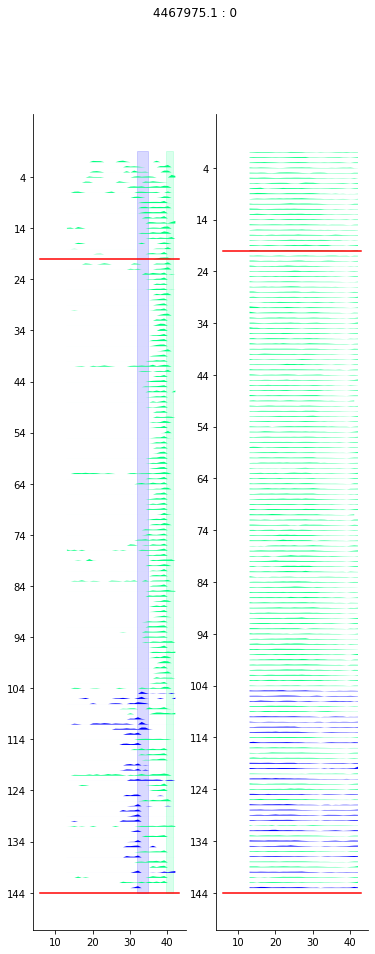

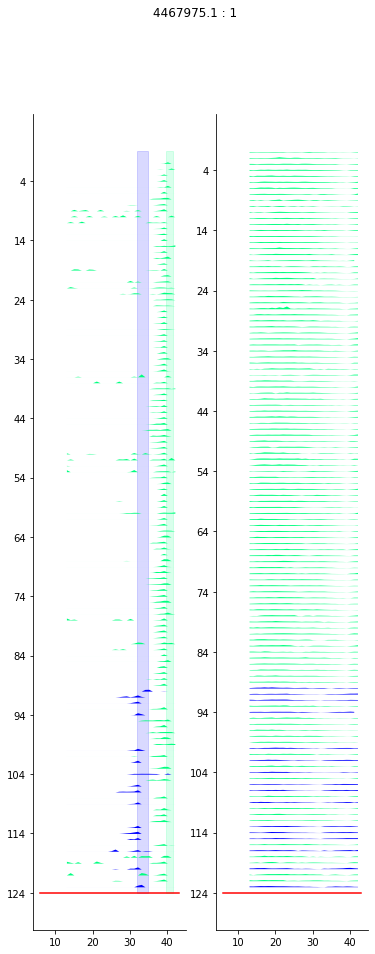

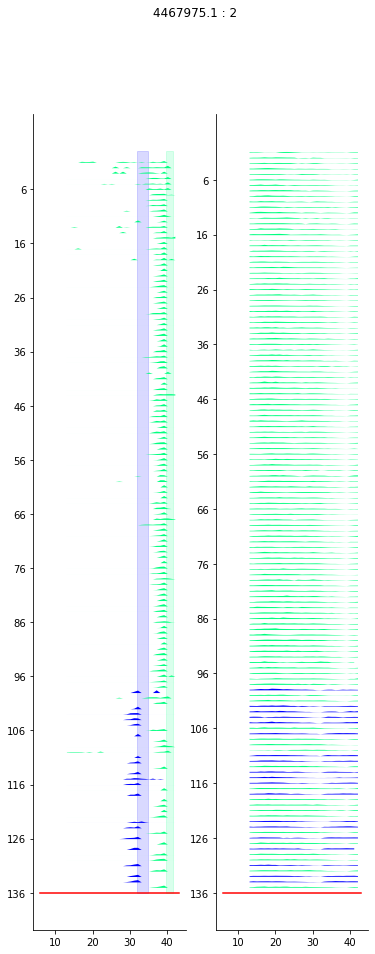

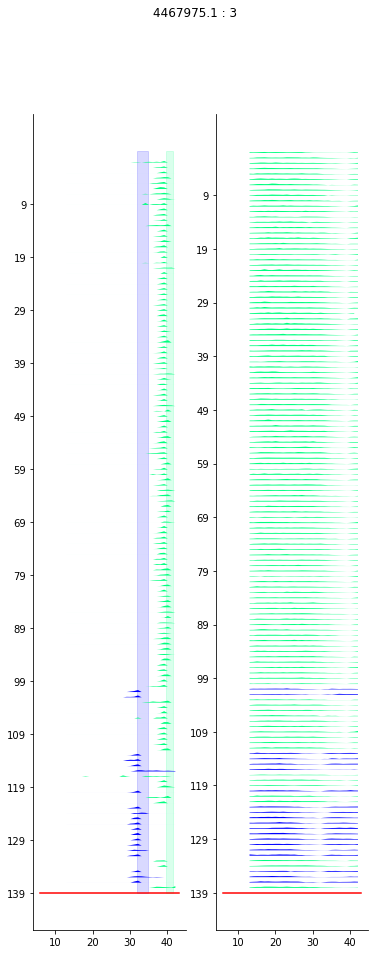

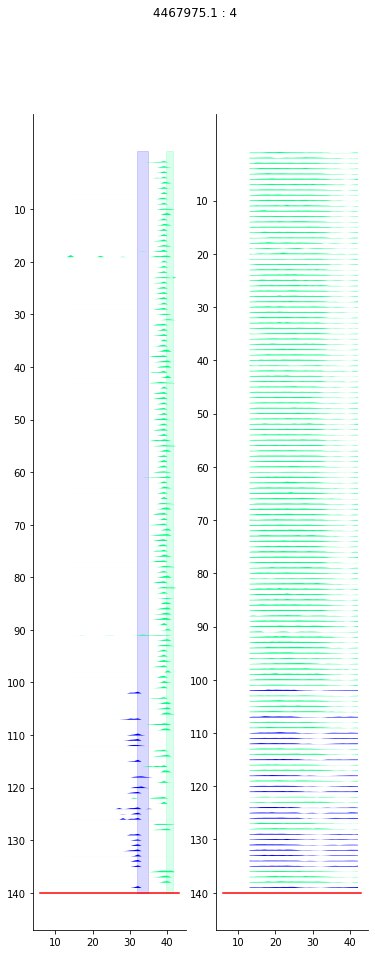

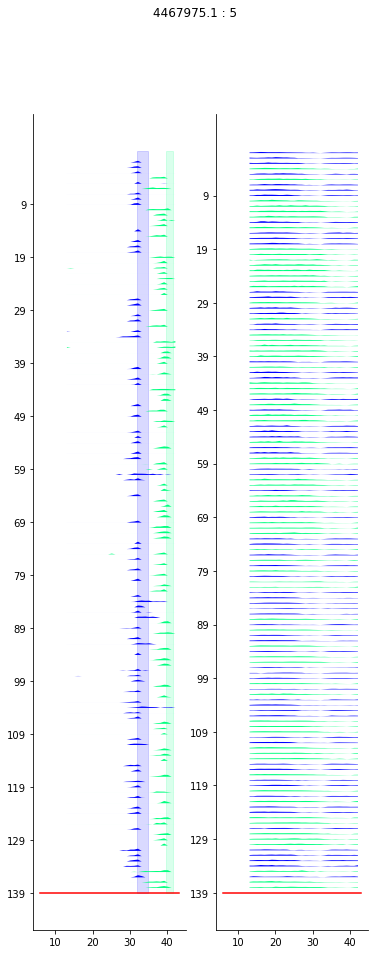

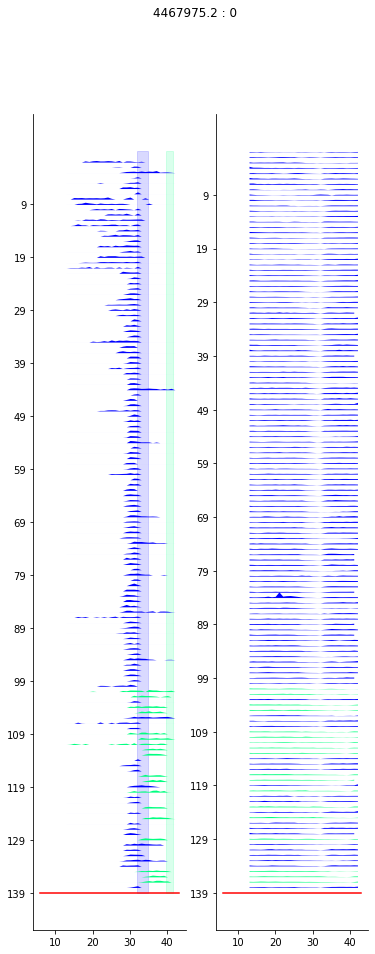

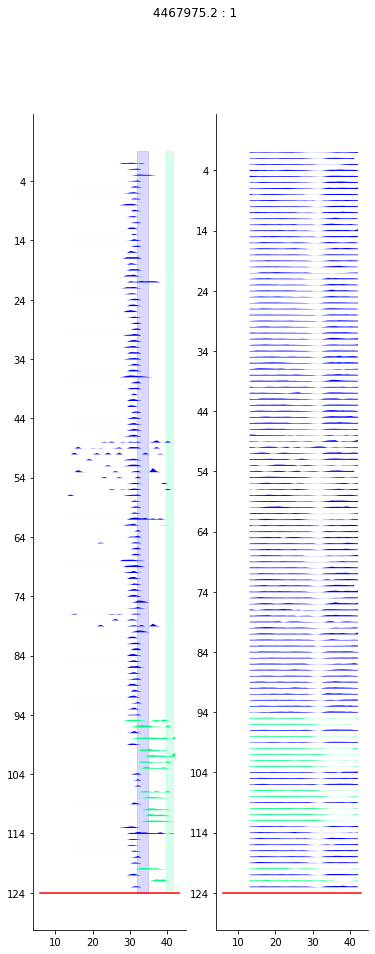

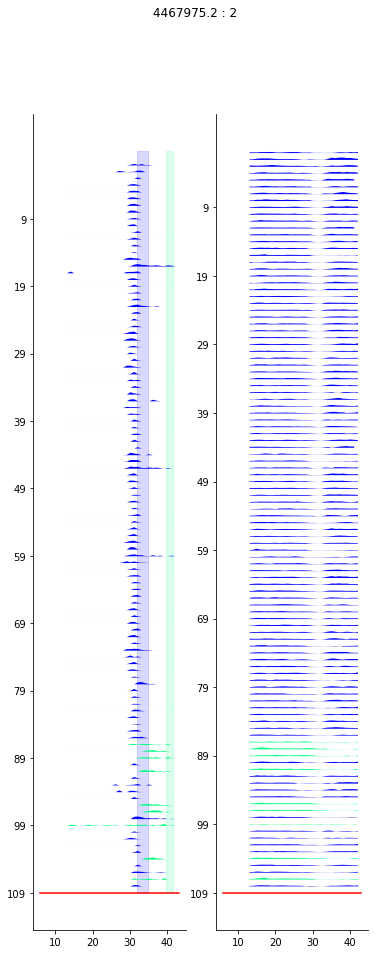

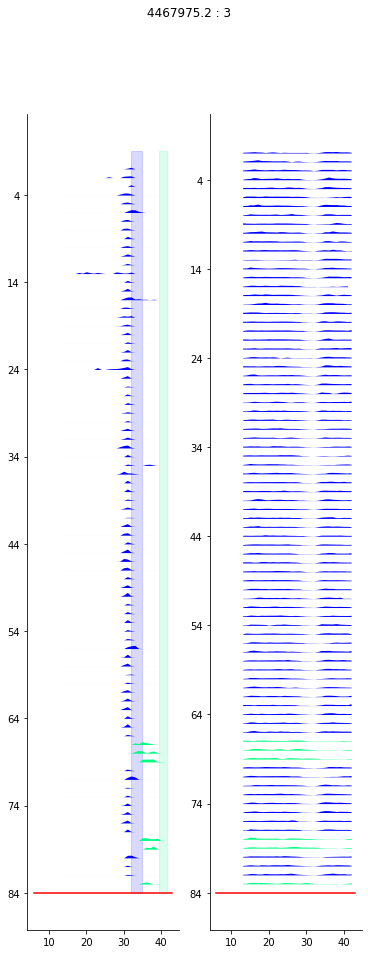

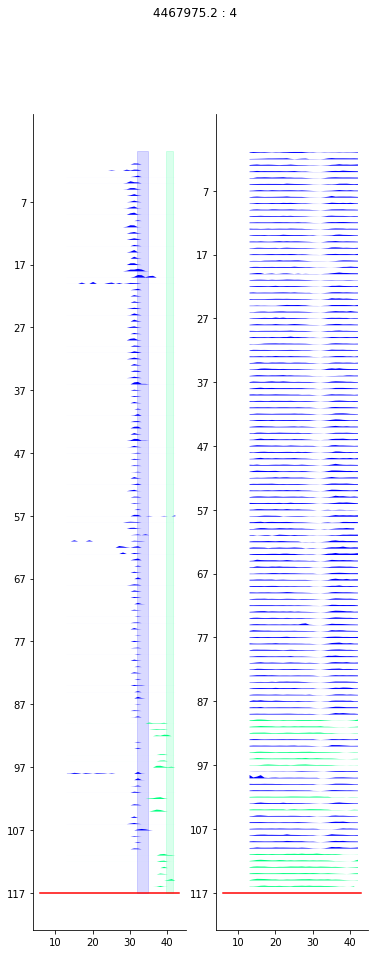

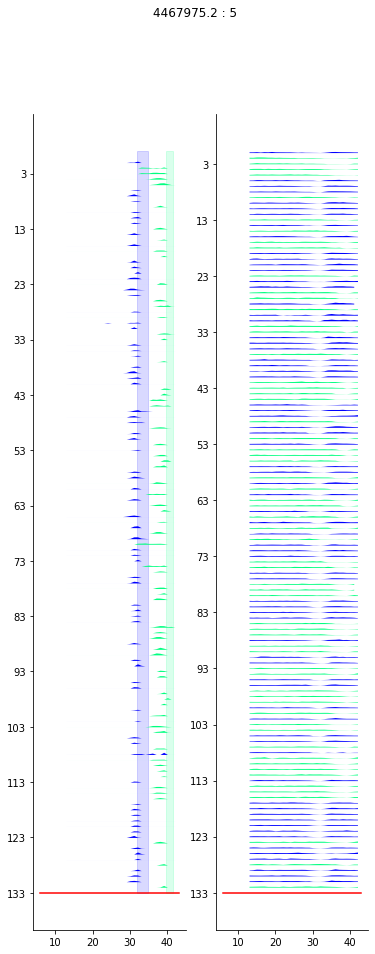

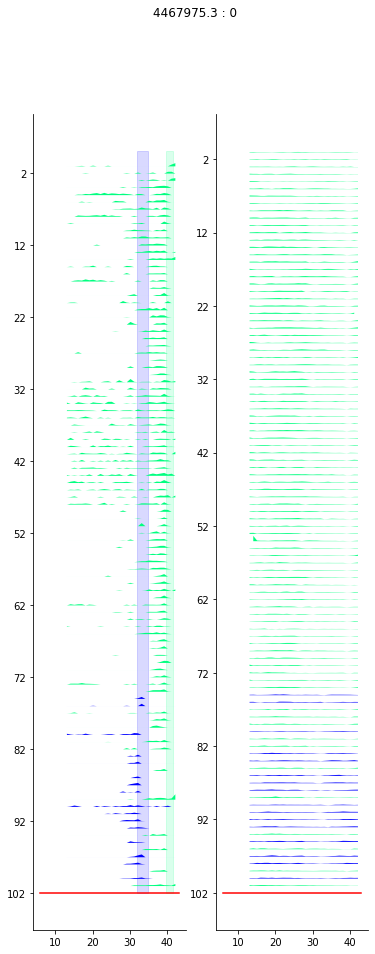

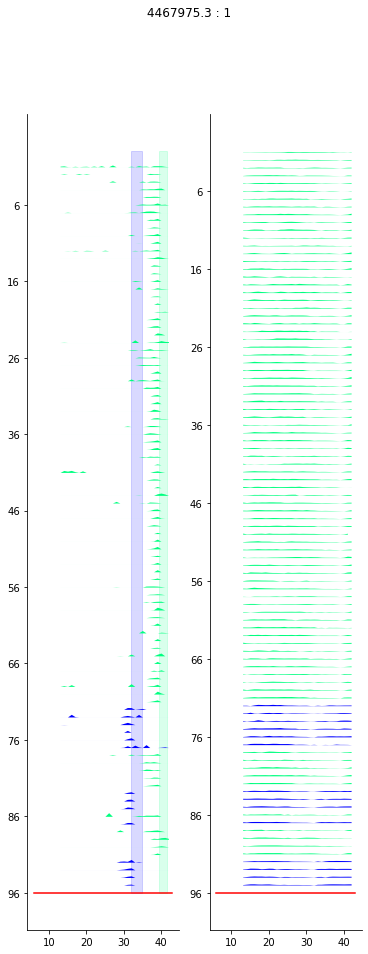

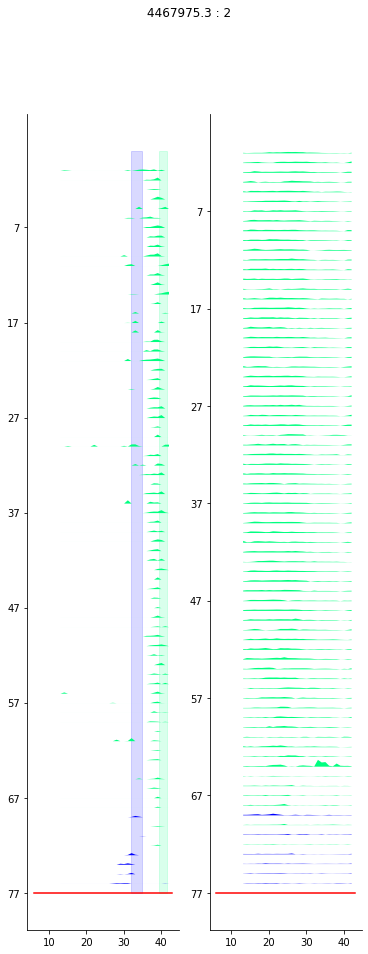

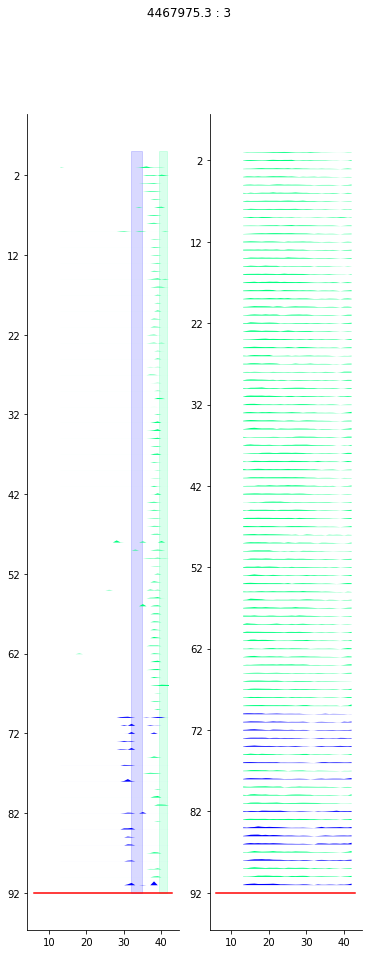

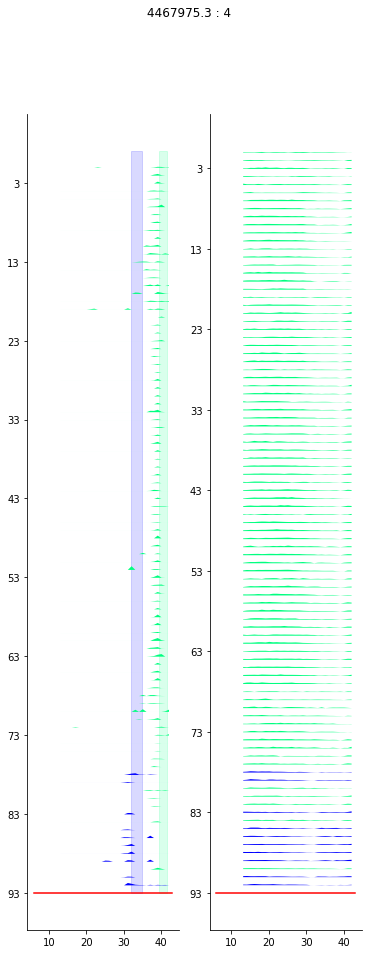

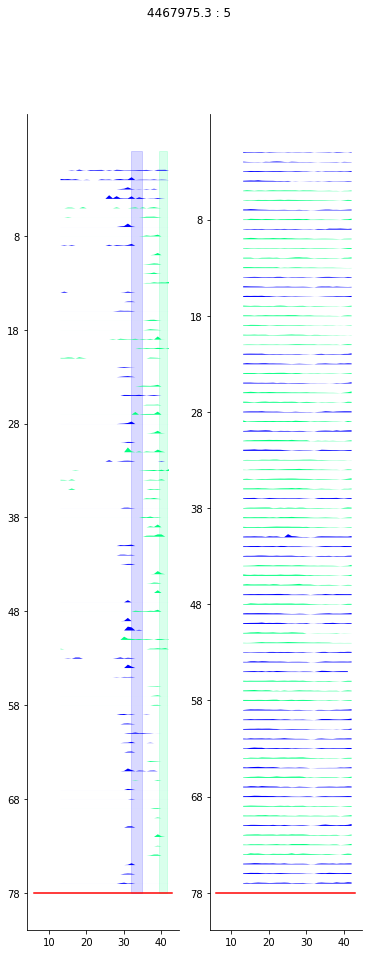

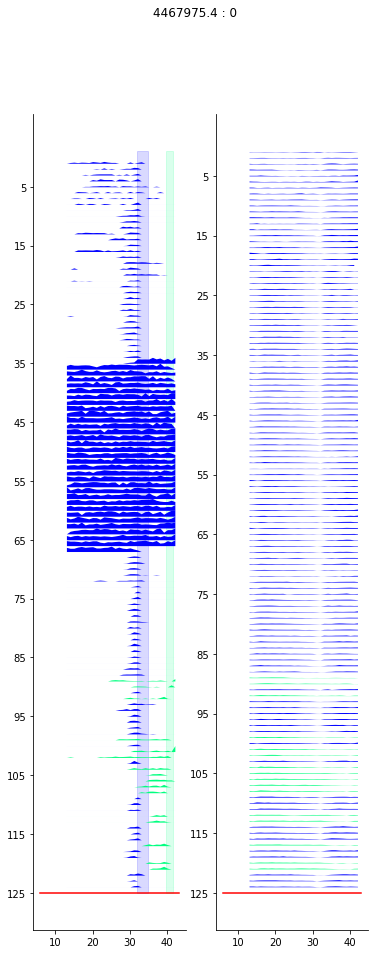

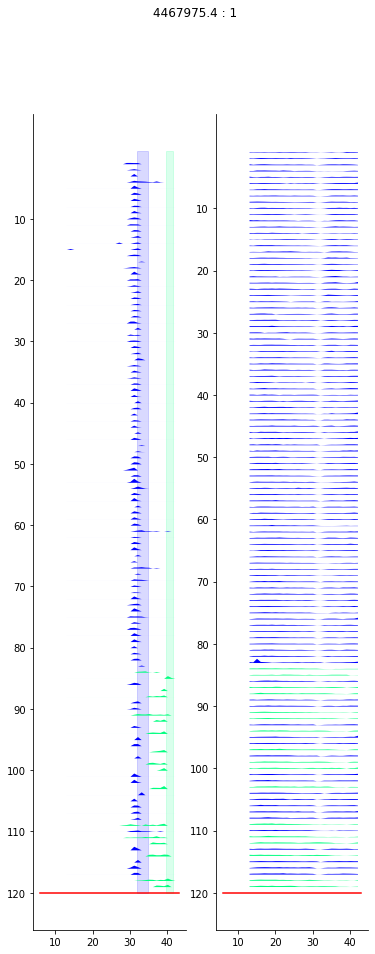

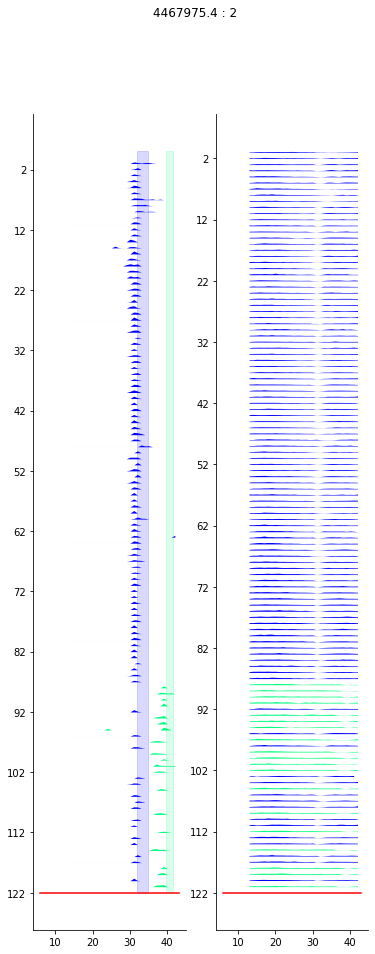

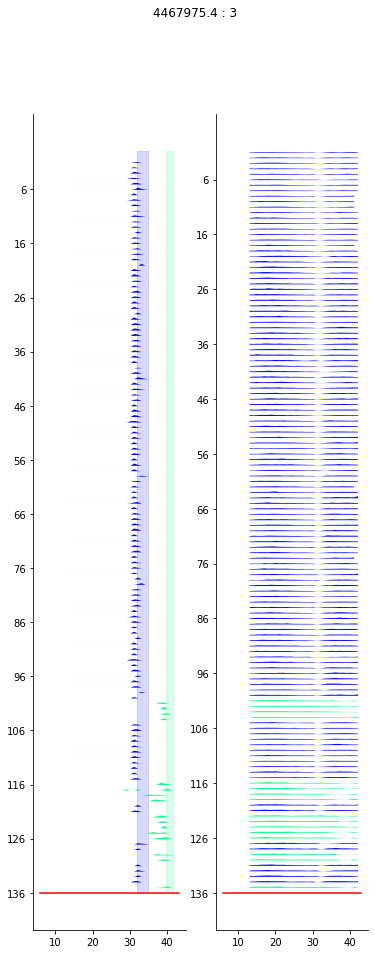

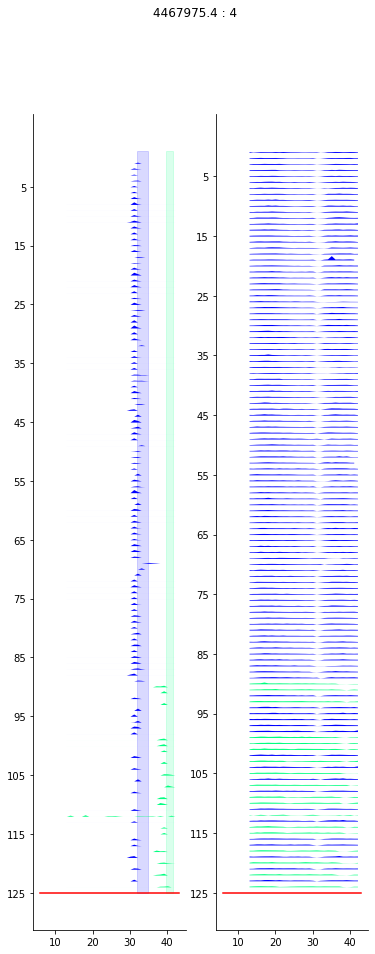

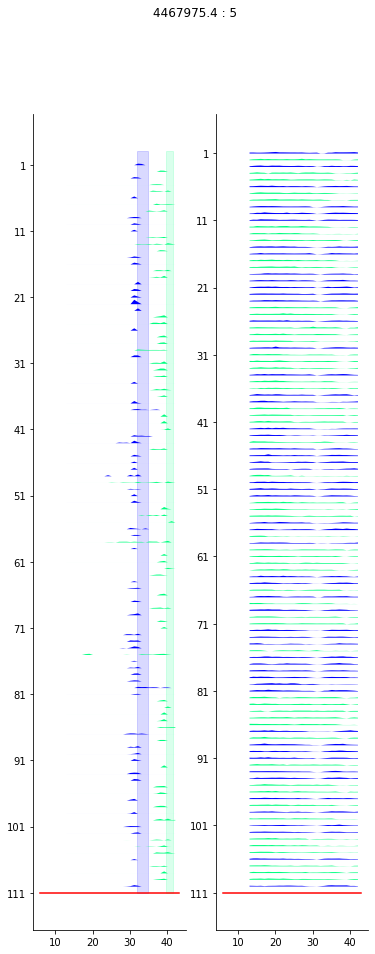

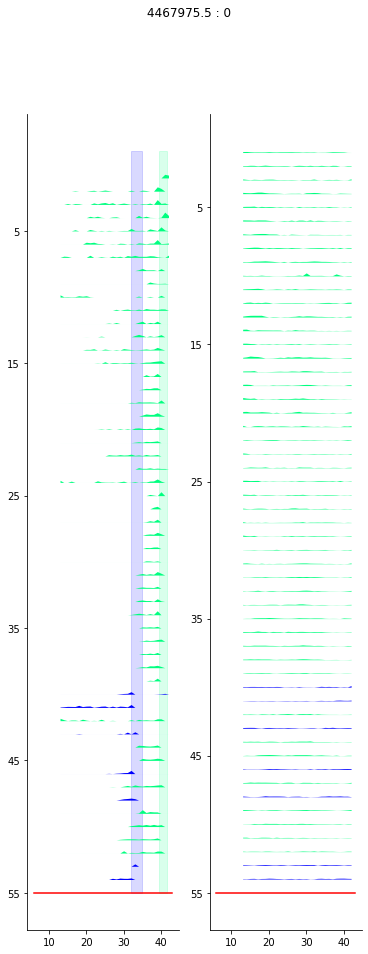

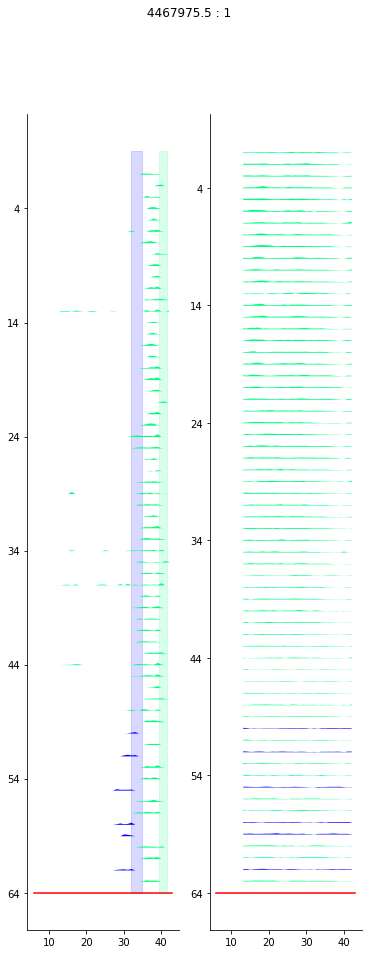

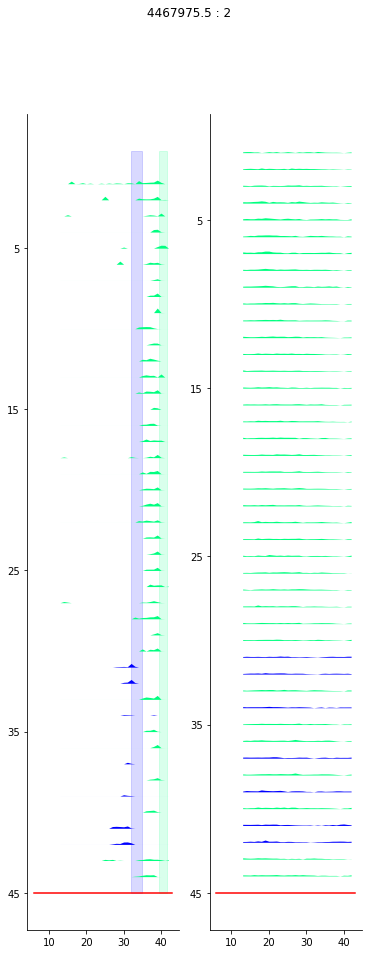

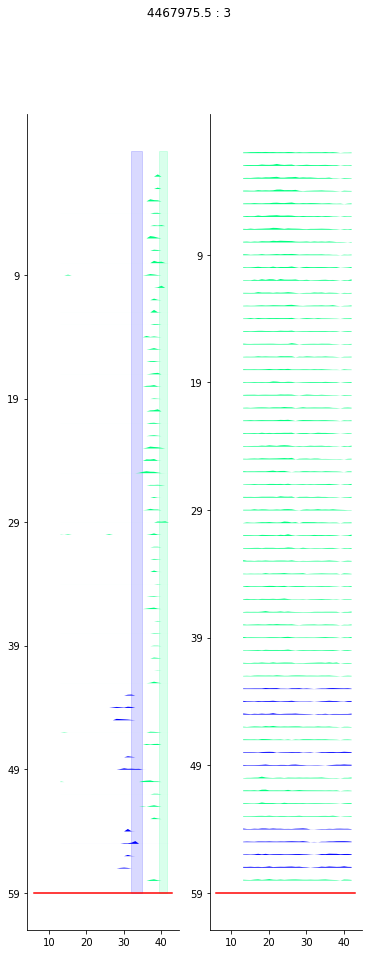

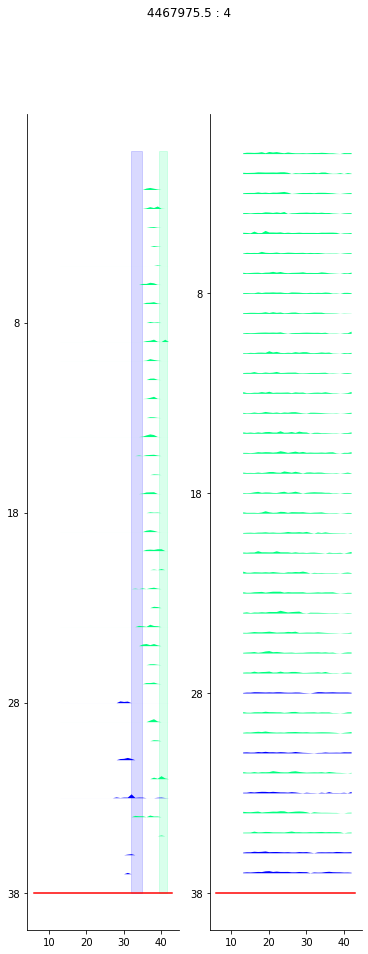

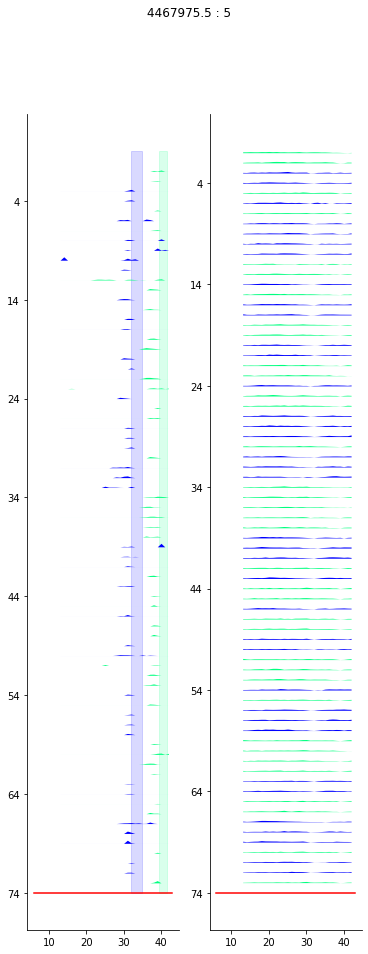

In [10]:
run_groupedsession_plots(KOs)
# !rclone copy {figdir_local} gdrive:{figdir_remote}

4467331.1
0 ({'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
1 ({'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
2 ({'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
3 ({'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4 ({'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
5 ({'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467331.2
0 ({'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
1 ({'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
2 ({'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
3 ({'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1}, {'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 2})
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4 ({'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
5 ({'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467332.1
0 ({'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
1 ({'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
2 ({'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
3 ({'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4 ({'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
5 ({'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467332.2
0 ({'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1}, {'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 2})
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
1 ({'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1}, {'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 3})
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
2 ({'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/anaconda3/envs/STX3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


3 ({'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4 ({'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
5 ({'date': '04_12_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467333.1
0 ({'date': '29_11_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
1 ({'date': '30_11_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
2 ({'date': '01_12_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
3 ({'date': '02_12_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4 ({'date': '03_12_2020', 'scene': 'YMaze_LNovel', 'session': 2},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
5 ({'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


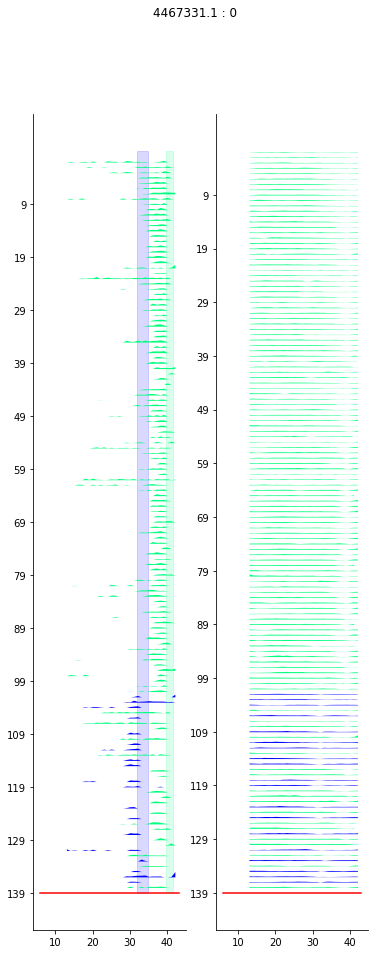

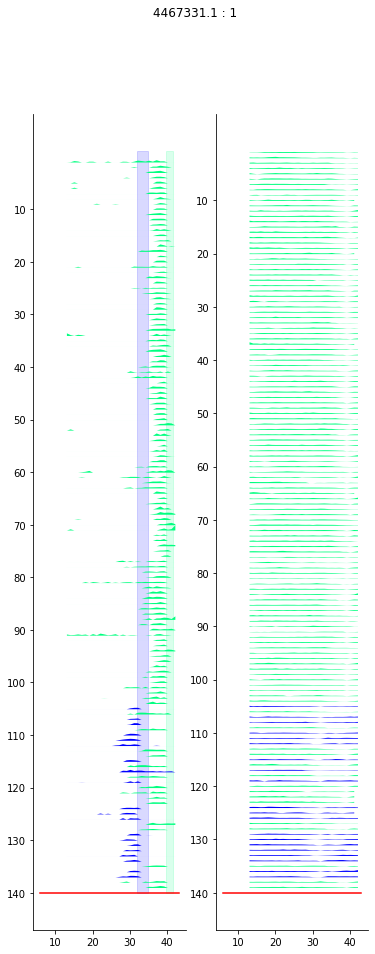

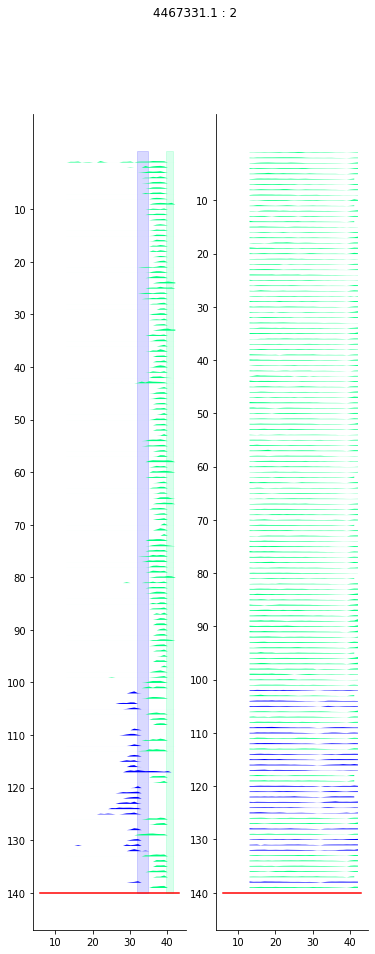

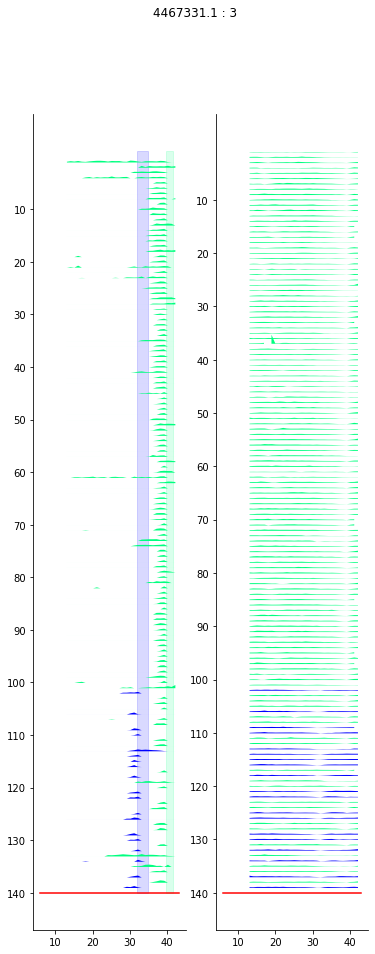

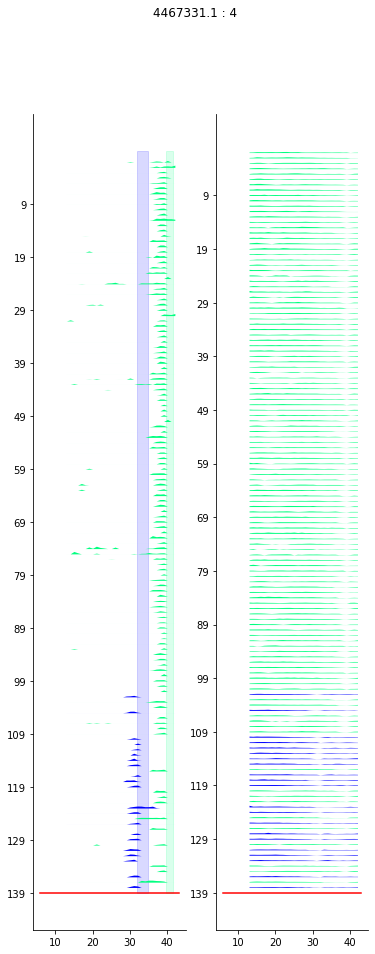

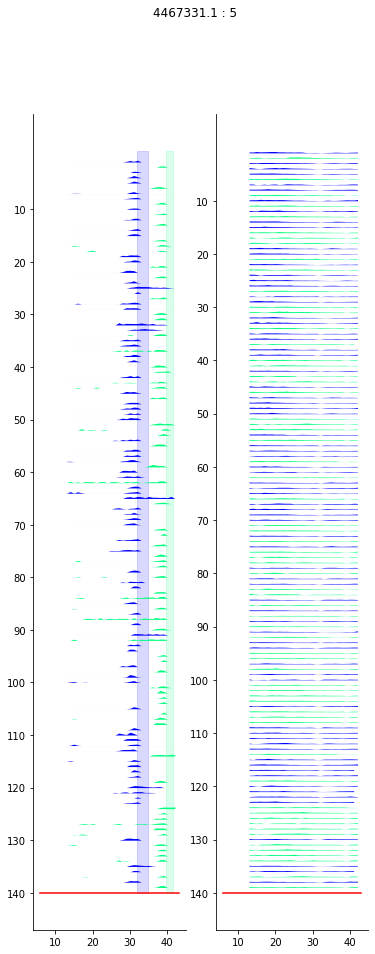

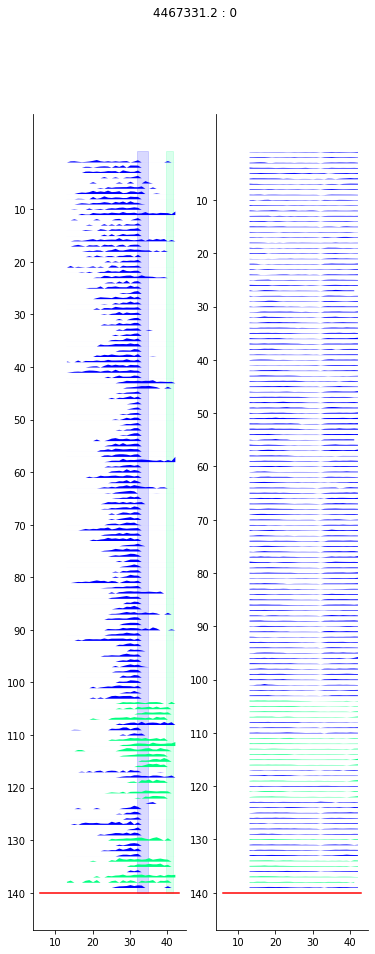

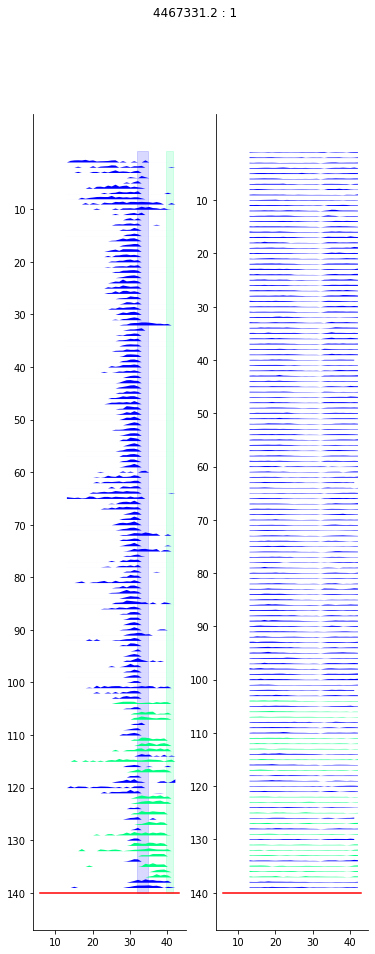

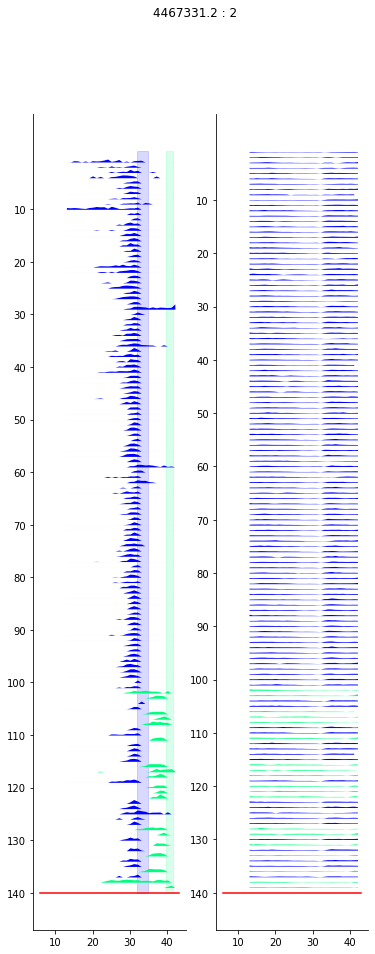

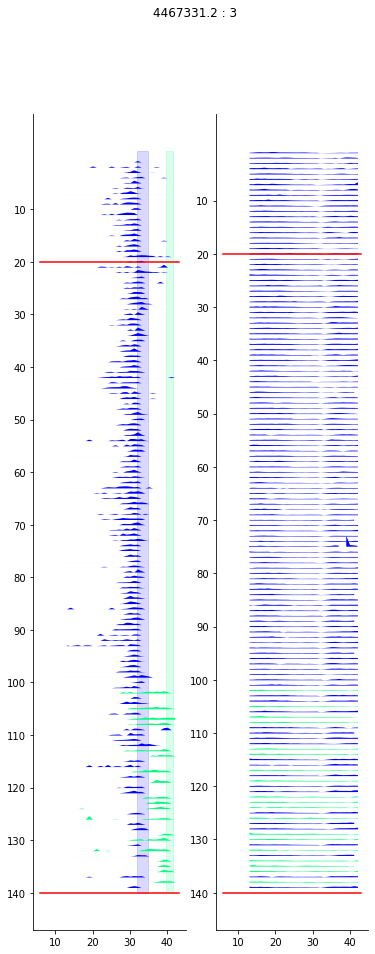

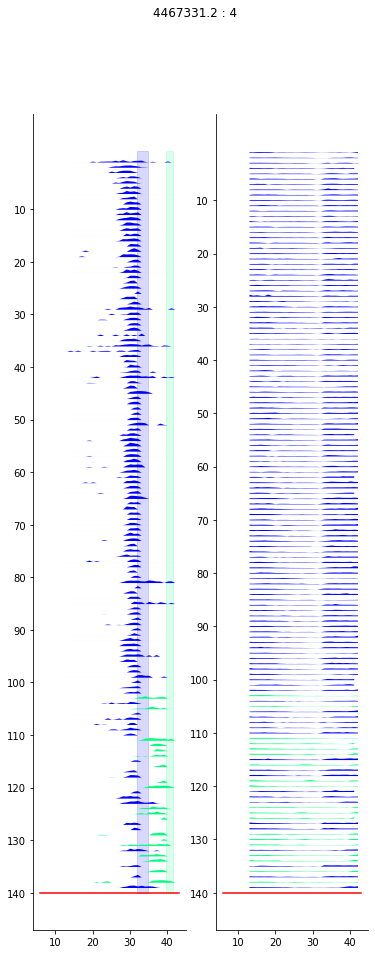

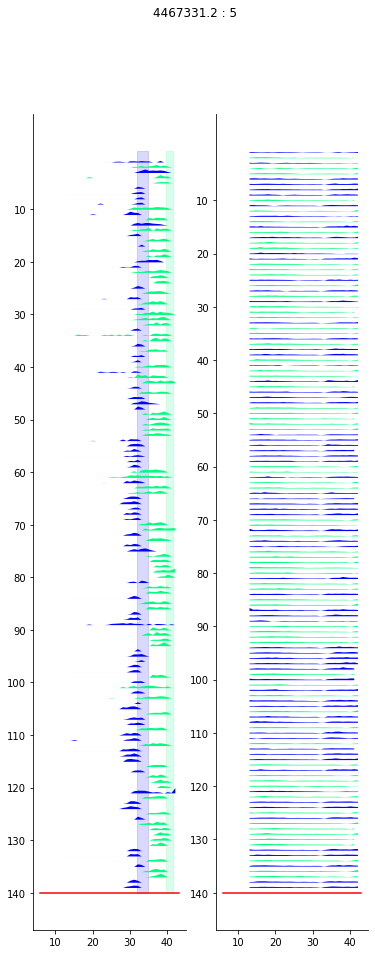

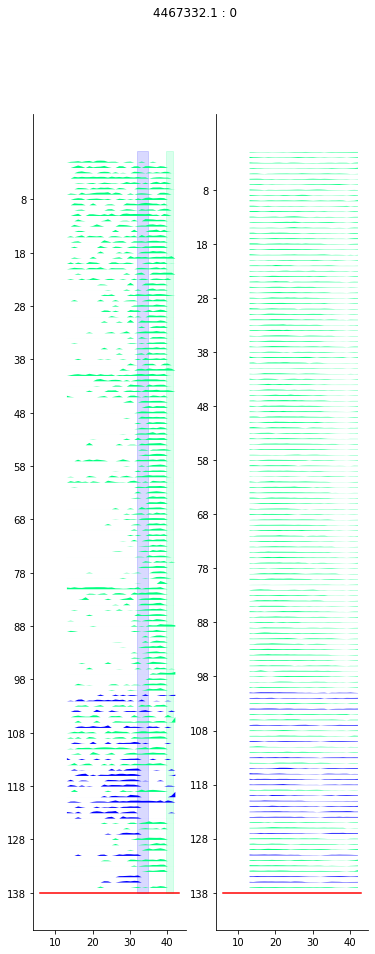

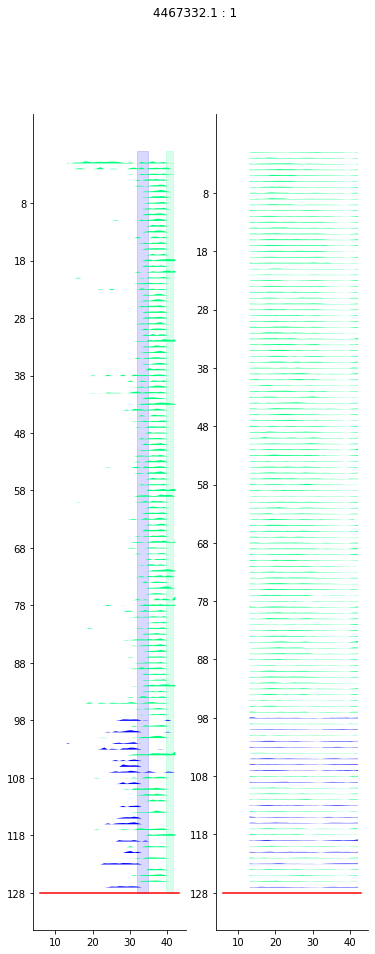

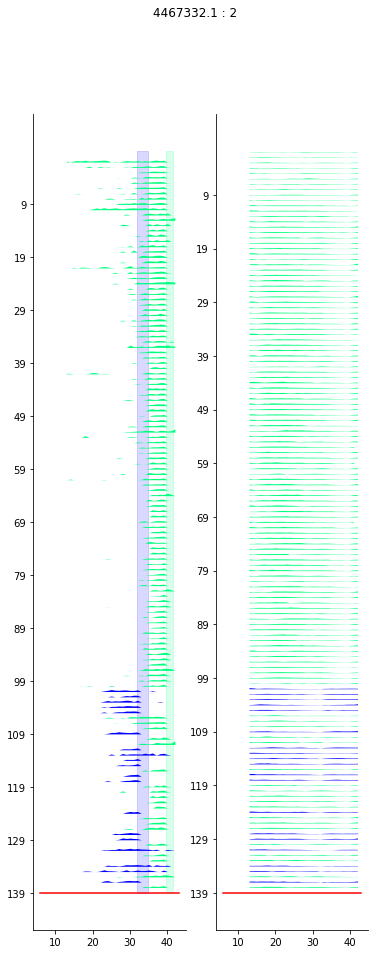

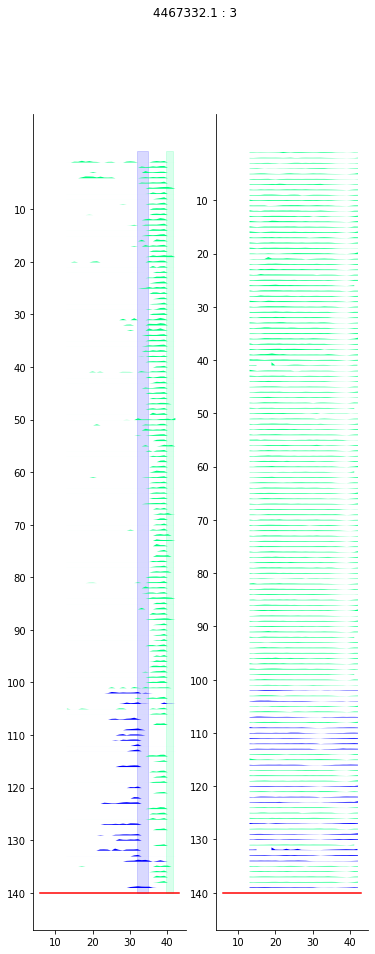

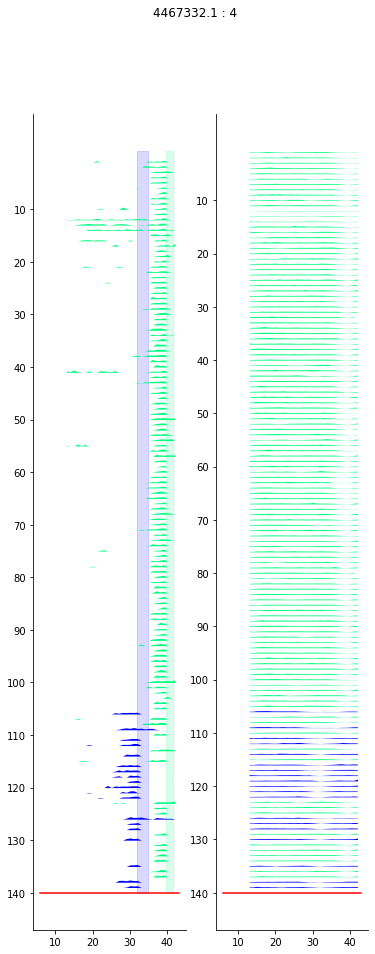

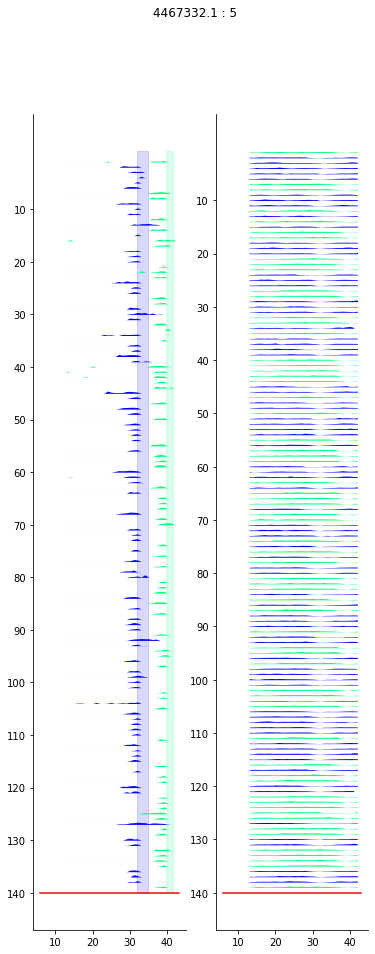

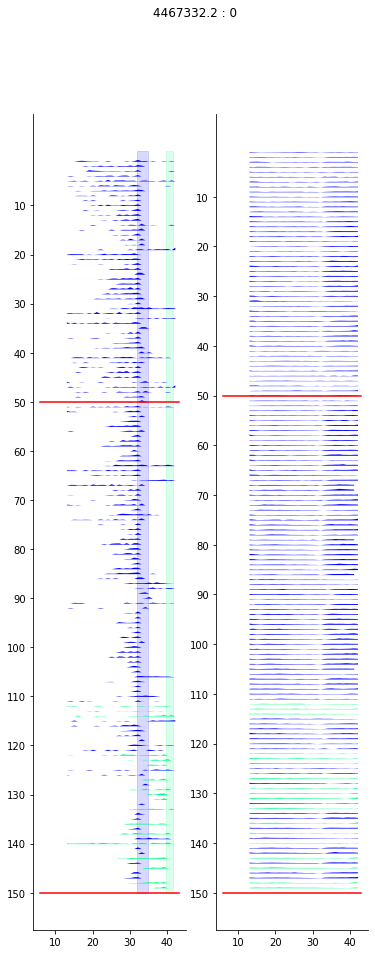

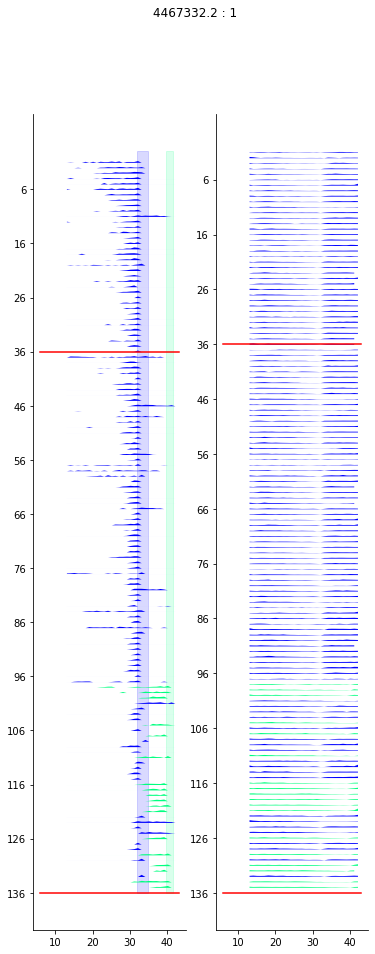

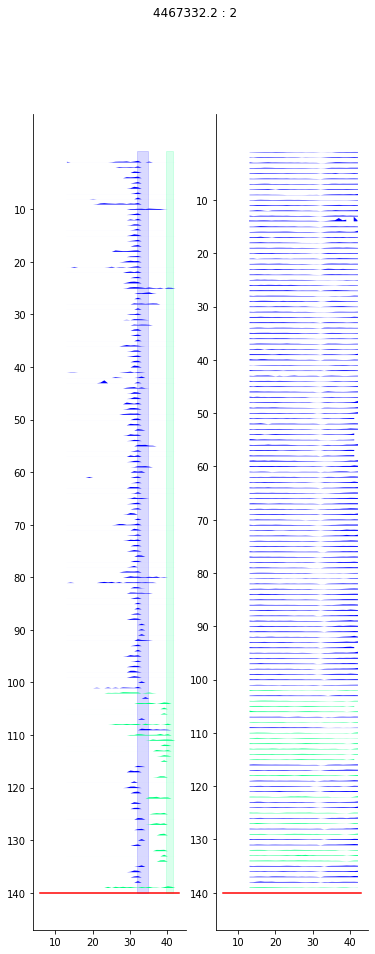

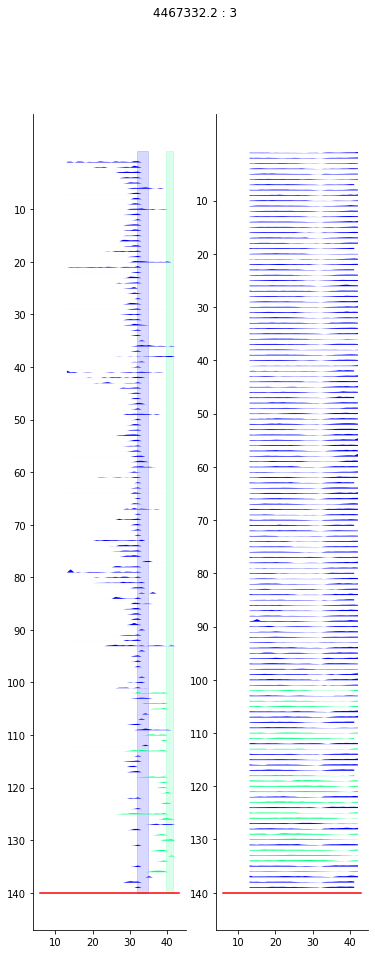

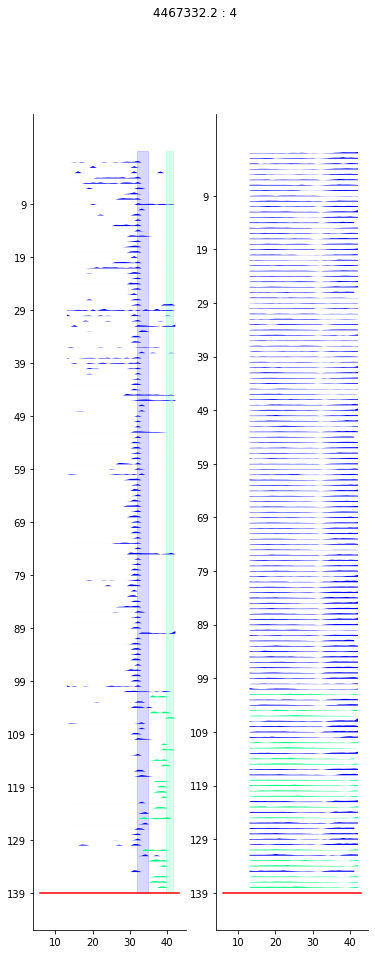

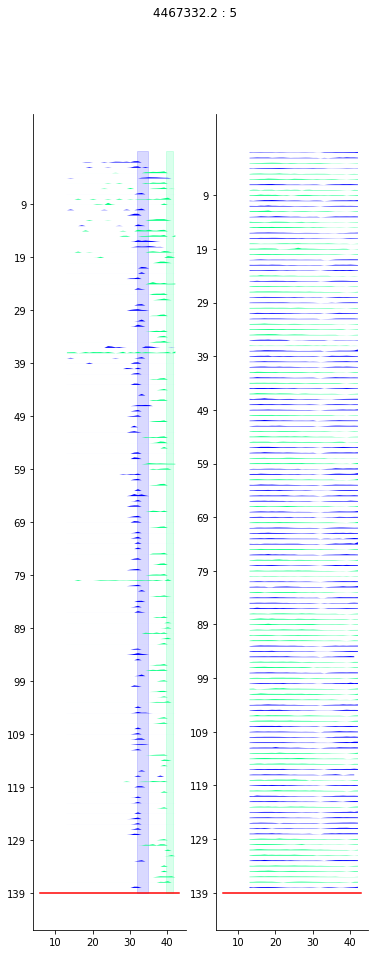

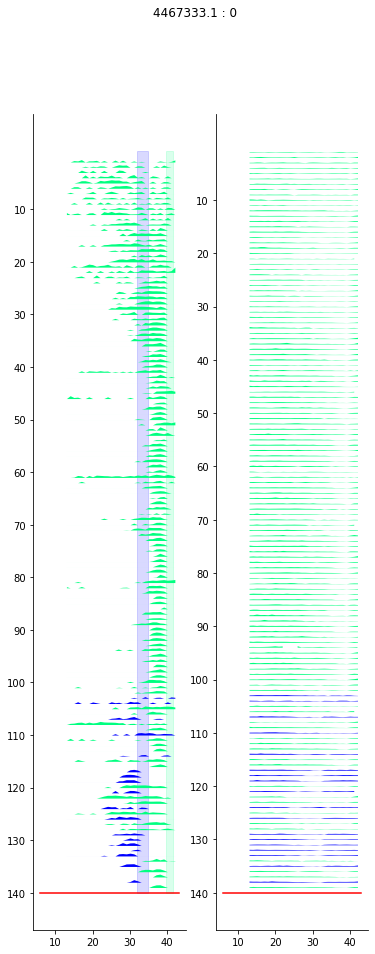

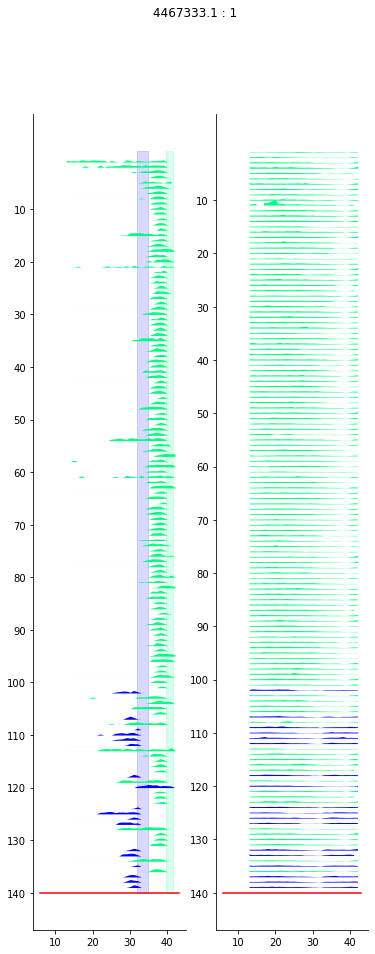

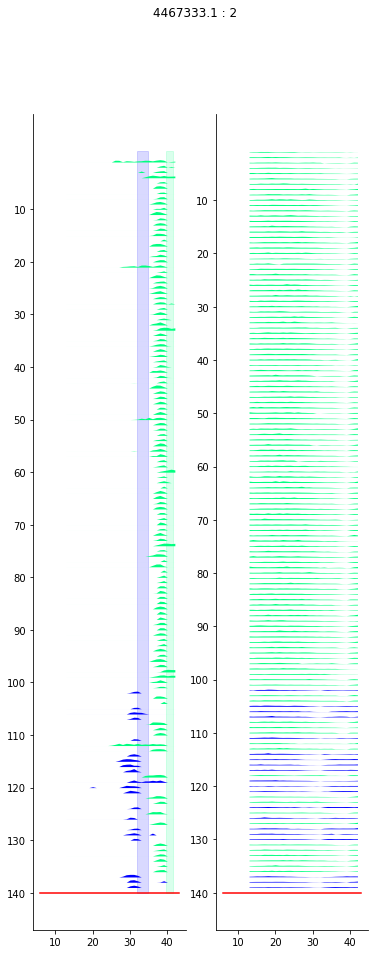

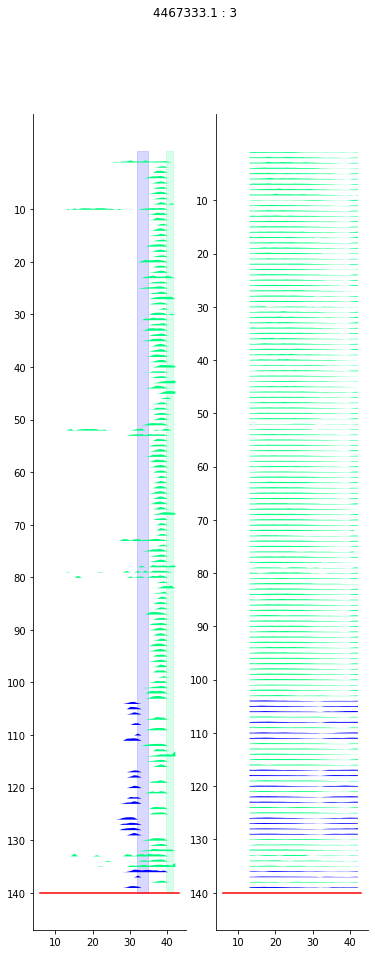

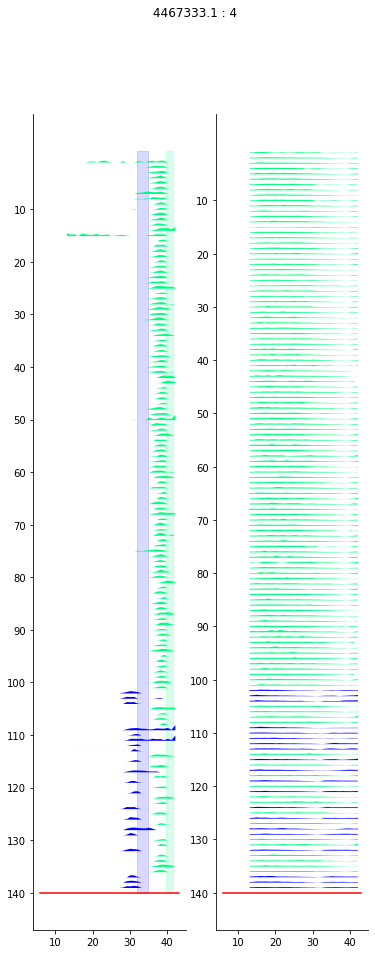

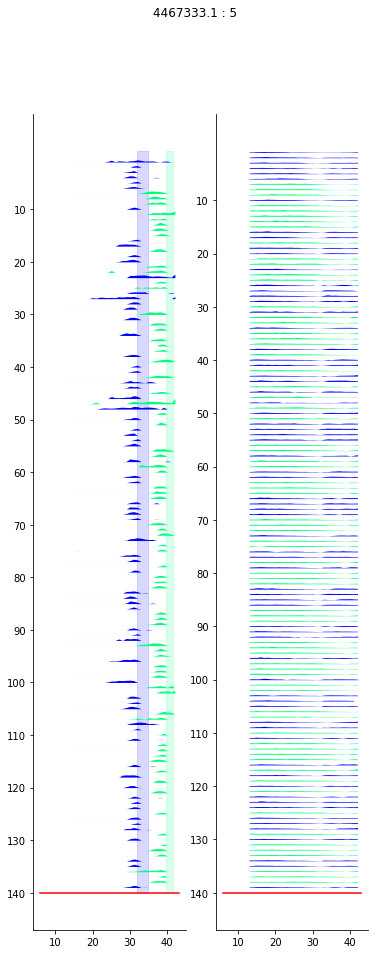

In [11]:
run_groupedsession_plots(CTRLs)
# !rclone copy {figdir_local} gdrive:{figdir_remote}

In [12]:
def novelarm_runningspeed(SessDict):
    arminds = slice(23-6,43-6)
    arm_speed_dict ={}
    for m,(mouse,days) in enumerate(SessDict.items()):
        print(mouse)    
#         LR, LICKS, SPEED = [],[],[]
        transition_trials = []
        famarm_speed,novelarm_speed= [], []
        
        for i, day in enumerate(days):
                  
            for sess_ind,session in enumerate(day):
                sess = TwoPUtils.sess.Session(basedir_VR=basedir_VR,mouse = mouse, date = session['date'], scene= session['scene'], 
                                              session = session['session'], VR_only=True, prompt_for_keys=False )
                sess.align_VR_to_2P()

                # get LR value for each trial
                lr_trial = get_LR_trial(sess)

                # make position binned lick rates and speed
                sess.add_timeseries(licks=sess.vr_data['lick']._values,speed= sess.vr_data['dz']._values)
                sess.add_pos_binned_trial_matrix(('licks','speed'),'t',min_pos=6,max_pos=43,bin_size=1,mat_only=True)

                armspeed =sess.trial_matrices['speed'][:,arminds].mean(axis=-1)

                if lr_trial[0] == 1:
                    famarm_speed.append(armspeed[lr_trial==1])
                    novelarm_speed.append(armspeed[lr_trial==-1])
                else:
                    famarm_speed.append(armspeed[lr_trial==-1])
                    novelarm_speed.append(armspeed[lr_trial==1])
                    
                
            
        arm_speed_dict[mouse] = {'fam':famarm_speed,'novel':novelarm_speed}
    return arm_speed_dict

In [13]:
ctrl_armspeed = novelarm_runningspeed(CTRLs)
ko_armspeed= novelarm_runningspeed(KOs)

4467331.1


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467331.2


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467332.1


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467332.2
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467333.1


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467975.1
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467975.2


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467975.3


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467975.4


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467975.5


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


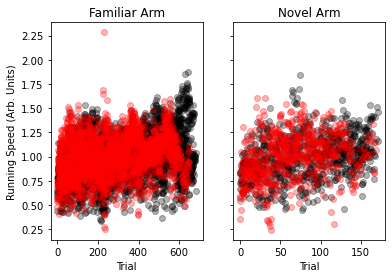

In [14]:
f,ax = plt.subplots(1,2,sharey=True)
for mouse, speeddict in ctrl_armspeed.items():
#     print(mouse,speeddict)
    famspeed = np.concatenate(speeddict['fam'])
    famspeed/=np.nanmean(famspeed)
    novspeed = np.concatenate(speeddict['novel'])
    novspeed/=np.nanmean(novspeed)
    ax[0].scatter(np.arange(famspeed.shape[0]),famspeed,color='black',alpha=.3)
    ax[1].scatter(np.arange(novspeed.shape[0]),novspeed,color='black',alpha=.3)
    
for mouse, speeddict in ko_armspeed.items():
    famspeed = np.concatenate(speeddict['fam'])
    famspeed/=np.nanmean(famspeed)
    novspeed = np.concatenate(speeddict['novel'])
    novspeed/=np.nanmean(novspeed)
    ax[0].scatter(np.arange(famspeed.shape[0]),famspeed,color='red',alpha=.3)
    ax[1].scatter(np.arange(novspeed.shape[0]),novspeed,color='red',alpha=.3)
    
ax[0].set_title('Familiar Arm')
ax[1].set_title('Novel Arm')
ax[0].set_ylabel('Running Speed (Arb. Units)')
ax[0].set_xlabel('Trial')
ax[1].set_xlabel('Trial')
f.savefig(os.path.join(figdir_local,"novel_arm_running.pdf"),format="pdf")

In [71]:
# mean vector length of licking

def licking_vectorlength(SessDict):
    
    vl_dict ={}
    for m,(mouse,days) in enumerate(SessDict.items()):
        print(mouse)    
#         LR, LICKS, SPEED = [],[],[]
#         transition_trials = []
        famarm_vl,novelarm_vl= [], []
        
        for i, day in enumerate(days):
                  
            for sess_ind,session in enumerate(day):
                sess = TwoPUtils.sess.Session(basedir_VR=basedir_VR,mouse = mouse, date = session['date'], scene= session['scene'], 
                                              session = session['session'], VR_only=True, prompt_for_keys=False )
                sess.align_VR_to_2P()

                # get LR value for each trial
                lr_trial = get_LR_trial(sess)

                # make position binned lick rates and speed
                sess.add_timeseries(licks=sess.vr_data['lick']._values,speed= sess.vr_data['dz']._values)
                sess.add_pos_binned_trial_matrix(('licks','speed'),'t',min_pos=6,max_pos=43,bin_size=1,mat_only=True)
                
                licks = np.copy(sess.trial_matrices['licks'])
                licks[np.isnan(licks)]=0.
                licks = sp.ndimage.filters.gaussian_filter1d(licks,1,axis=-1)
                licks+=1E-3
                licks=licks/licks.sum(axis=-1,keepdims=True)
                phase = np.linspace(0,1,num=licks.shape[1])[np.newaxis,:]
                mean = np.sum(licks*phase,axis=-1,keepdims=True)
                lick_vl = (licks*np.power(phase - mean,2)).sum(axis=-1)
                
#                 phase = np.linspace(0,2*np.pi,num=licks.shape[1])
#                 phase = np.array([complex(0,p) for p in phase.tolist()])
#                 lick_vl = np.linalg.norm(licks,axis=-1,ord=2)
#                 lick_vl = 1-np.abs(np.sum(licks*np.exp(phase[np.newaxis,:]),axis=-1))
#                 print(lick_vl)
                if mouse=='4467975.4' and i==0 and sess_ind==0:
                    lick_vl[24:68]=np.nan
                

                if lr_trial[0] == 1:
                    famarm_vl.append(lick_vl[lr_trial==1])
                    novelarm_vl.append(lick_vl[lr_trial==-1])
                else:
                    famarm_vl.append(lick_vl[lr_trial==-1])
                    novelarm_vl.append(lick_vl[lr_trial==1])
                    
                
            
        vl_dict[mouse] = {'fam':famarm_vl,'novel':novelarm_vl}
    return vl_dict
    
    

In [72]:
ctrl_lickvl = licking_vectorlength(CTRLs)
ko_lickvl = licking_vectorlength(KOs)

4467331.1


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467331.2


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467332.1


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467332.2
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467333.1


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467975.1
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467975.2


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467975.3


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467975.4


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467975.5


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


In [73]:
ctrl_famvl_arr = np.zeros([5,700])
ctrl_famvl_arr[:]=np.nan

ctrl_novvl_arr = np.zeros([5,200])
ctrl_novvl_arr[:]=np.nan

# ctrl_famvl_slope = []
# ctrl_novvl_slope - []
for i,(m,vldict) in enumerate(ctrl_lickvl.items()):
    famvl = np.concatenate(vldict['fam'])
    novvl = np.concatenate(vldict['novel'])
    
    print(famvl.shape,novvl.shape)
    
    
#     lr = hubreg().fit(np.arange(30)[:,np.newaxis],early_rzone_licks[:30])
#     slopes[m] = lr.coef_
    
    
    ctrl_famvl_arr[i,:famvl.size] = sp.ndimage.filters.gaussian_filter1d(famvl,5)
    ctrl_novvl_arr[i,:novvl.size] = sp.ndimage.filters.gaussian_filter1d(novvl,5)


ko_famvl_arr = np.zeros([5,700])
ko_famvl_arr[:]=np.nan

ko_novvl_arr = np.zeros([5,200])
ko_novvl_arr[:]=np.nan
for i,(m,vldict) in enumerate(ko_lickvl.items()):
    famvl = np.concatenate(vldict['fam'])
    novvl = np.concatenate(vldict['novel'])
    print(famvl.shape,novvl.shape)
    ko_famvl_arr[i,:famvl.size] = sp.ndimage.filters.gaussian_filter1d(famvl,5)
    ko_novvl_arr[i,:novvl.size] = sp.ndimage.filters.gaussian_filter1d(novvl,5)

(673,) (165,)
(674,) (166,)
(652,) (173,)
(685,) (159,)
(671,) (169,)
(652,) (170,)
(580,) (126,)
(434,) (104,)
(595,) (144,)
(261,) (74,)


/home/mplitt/anaconda3/envs/STX3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mplitt/anaconda3/envs/STX3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/home/mplitt/anaconda3/envs/STX3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
/home/mplitt/anaconda3/envs/STX3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice


0.009023438818080326
0.028280122568276955


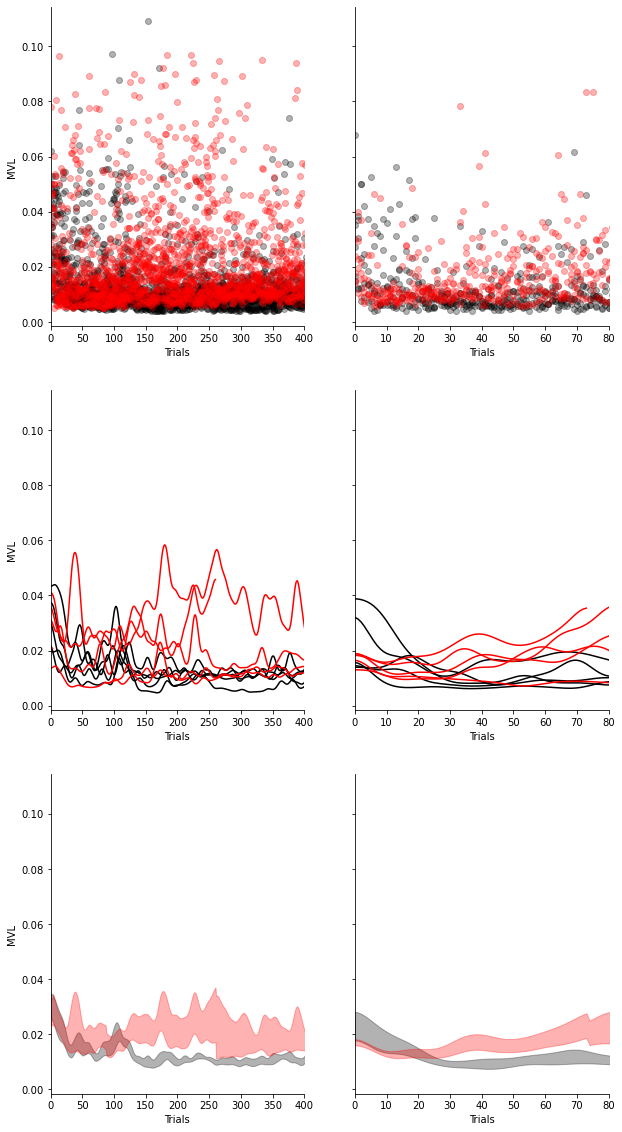

In [74]:
f,ax = plt.subplots(3,2,sharey=True,figsize=[10,20])

ctrl_fam_mu, ctrl_fam_sem = np.nanmean(ctrl_famvl_arr,axis=0), sp.stats.sem(ctrl_famvl_arr,axis=0,nan_policy='omit')
ctrl_nov_mu, ctrl_nov_sem = np.nanmean(ctrl_novvl_arr,axis=0), sp.stats.sem(ctrl_novvl_arr,axis=0,nan_policy='omit')
for mouse, vldict in ctrl_lickvl.items():
#     print(mouse,vldict)
    famvl = np.concatenate(vldict['fam'])
    novvl = np.concatenate(vldict['novel'])
#     famvl = vldict['fam'][0]
#     novvl = vldict['novel'][0]
    ax[0,0].scatter(np.arange(famvl.shape[0]),famvl,color='black',alpha=.3)
    ax[0,1].scatter(np.arange(novvl.shape[0]),novvl,color='black',alpha=.3)
    ax[1,0].plot(np.arange(famvl.shape[0]),sp.ndimage.filters.gaussian_filter1d(famvl,5),color='black')
    ax[1,1].plot(np.arange(novvl.shape[0]),sp.ndimage.filters.gaussian_filter1d(novvl,5),color='black')
    
ax[2,0].fill_between(np.arange(ctrl_fam_mu.shape[0]), ctrl_fam_mu+ctrl_fam_sem, ctrl_fam_mu-ctrl_fam_sem,color='black',alpha=.3)
ax[2,1].fill_between(np.arange(ctrl_nov_mu.shape[0]), ctrl_nov_mu+ctrl_nov_sem, ctrl_nov_mu-ctrl_nov_sem,color='black',alpha=.3)


ko_fam_mu, ko_fam_sem = np.nanmean(ko_famvl_arr,axis=0), sp.stats.sem(ko_famvl_arr,axis=0,nan_policy='omit')
ko_nov_mu, ko_nov_sem = np.nanmean(ko_novvl_arr,axis=0), sp.stats.sem(ko_novvl_arr,axis=0,nan_policy='omit')
for mouse, vldict in ko_lickvl.items():
#     print(mouse,vldict)
    famvl = np.concatenate(vldict['fam'])
    novvl = np.concatenate(vldict['novel'])
#     famvl = vldict['fam'][0]
#     novvl = vldict['novel'][0]
    ax[0,0].scatter(np.arange(famvl.shape[0]),famvl,color='red',alpha=.3)
    ax[0,1].scatter(np.arange(novvl.shape[0]),novvl,color='red',alpha=.3)
    ax[1,0].plot(np.arange(famvl.shape[0]),sp.ndimage.filters.gaussian_filter1d(famvl,5),color='red')
    ax[1,1].plot(np.arange(novvl.shape[0]),sp.ndimage.filters.gaussian_filter1d(novvl,5),color='red')

ax[2,0].fill_between(np.arange(ko_fam_mu.shape[0]), ko_fam_mu+ko_fam_sem, ko_fam_mu-ko_fam_sem,color='red',alpha=.3)
ax[2,1].fill_between(np.arange(ko_nov_mu.shape[0]), ko_nov_mu+ko_nov_sem, ko_nov_mu-ko_nov_sem,color='red',alpha=.3)

fam_stat,fam_p = np.zeros([400,]),np.zeros([400,])
for c in range(400):
    _stat,_p = sp.stats.ranksums(ctrl_famvl_arr[:,c],ko_famvl_arr[:,c])
#     print(_stat,_p)
    fam_stat[c],fam_p[c]=_stat,_p
    
p_sort = np.sort(fam_p)
i = 0
while p_sort[i]<=i/p_sort.shape[0]*.05 and i<p_sort.shape[0]:
    i+=1
    
p_thresh = p_sort[i]
print(p_thresh)

_trials = np.arange(400)
_stars = .8*np.ones(_trials.shape)
# ax[2,0].scatter(_trials[fam_p<=p_thresh],_stars[fam_p<=p_thresh],marker='x',color='blue')


nov_stat,nov_p = np.zeros([100,]),np.zeros([100,])
for c in range(80):
    _stat,_p = sp.stats.ranksums(ctrl_novvl_arr[:,c],ko_novvl_arr[:,c])
#     print(_stat,_p)
    nov_stat[c],nov_p[c]=_stat,_p
    
p_sort = np.sort(nov_p)
i = 0
while p_sort[i]<=i/p_sort.shape[0]*.05 and i<p_sort.shape[0]:
    i+=1
    
p_thresh = p_sort[i]
print(p_thresh)

_trials = np.arange(100)
_stars = .8*np.ones(_trials.shape)
# ax[2,1].scatter(_trials[nov_p<=p_thresh],_stars[nov_p<=p_thresh],marker='x',color='blue')


for i in range(3):
    ax[i,0].set_xlim([0,400])
    ax[i,1].set_xlim([0,80])
    for j in range(2):
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].spines['right'].set_visible(False)
        
        ax[i,j].set_xlabel('Trials')
        ax[i,j]

ax[0,0].set_ylabel('MVL')
ax[1,0].set_ylabel('MVL')
ax[2,0].set_ylabel('MVL')
f.savefig(os.path.join(figdir_local,"licking_mvl.pdf"),format="pdf")

In [22]:
KOs_reversals = {'4467975.1': (({'date': '04_10_2020', 'scene':'YMaze_LNovel','session':1}, {'date':'04_10_2020','scene':'YMaze_RewardReversal', 'session':2}), ##########################
                     ({'date': '05_10_2020', 'scene':'YMaze_RewardReversal','session':1},),
                     ({'date': '06_10_2020', 'scene':'YMaze_RewardReversal','session':1}, {'date':'06_10_2020','scene':'YMaze_LNovel', 'session':1})),
       '4467975.2': (({'date': '04_10_2020', 'scene':'YMaze_LNovel','session':1}, {'date':'04_10_2020','scene':'YMaze_RewardReversal', 'session':1}), ##########################
                     ({'date': '05_10_2020', 'scene':'YMaze_RewardReversal','session':1},),
                     ({'date': '06_10_2020', 'scene':'YMaze_RewardReversal','session':1}, {'date':'06_10_2020','scene':'YMaze_LNovel', 'session':1})),
       '4467975.3': (({'date': '04_10_2020', 'scene':'YMaze_LNovel','session':1}, {'date':'04_10_2020','scene':'YMaze_RewardReversal', 'session':1}), ##########################
                     ({'date': '05_10_2020', 'scene':'YMaze_RewardReversal','session':1},),
                     ({'date': '06_10_2020', 'scene':'YMaze_RewardReversal','session':1}, {'date':'06_10_2020','scene':'YMaze_LNovel', 'session':1})),
       '4467975.4': (({'date': '04_10_2020', 'scene':'YMaze_LNovel','session':1}, {'date':'04_10_2020','scene':'YMaze_RewardReversal', 'session':1}), ##########################
                     ({'date': '05_10_2020', 'scene':'YMaze_RewardReversal','session':1},),
                     ({'date': '06_10_2020', 'scene':'YMaze_RewardReversal','session':1}, {'date':'06_10_2020','scene':'YMaze_LNovel', 'session':1})),
       '4467975.5': (({'date': '04_10_2020', 'scene':'YMaze_LNovel','session':1}, {'date':'04_10_2020','scene':'YMaze_RewardReversal', 'session':1}), ##########################
                     ({'date': '05_10_2020', 'scene':'YMaze_RewardReversal','session':1},),
                     ({'date': '06_10_2020', 'scene':'YMaze_RewardReversal','session':1}, {'date':'06_10_2020','scene':'YMaze_LNovel', 'session':1}))}


CTRLs_reversals = {'4467331.1': (({'date': '05_12_2020', 'scene':'YMaze_LNovel','session':1}, {'date':'05_12_2020','scene':'YMaze_RewardReversal', 'session':1}), ##########################
                     ({'date': '06_12_2020', 'scene':'YMaze_RewardReversal','session':2},),
                     ({'date': '07_12_2020', 'scene':'YMaze_RewardReversal','session':1}, {'date':'07_12_2020','scene':'YMaze_LNovel', 'session':1})),
       '4467331.2': (({'date': '05_12_2020', 'scene':'YMaze_LNovel','session':1}, {'date':'05_12_2020','scene':'YMaze_RewardReversal', 'session':1}), ##########################
                     ({'date': '06_12_2020', 'scene':'YMaze_RewardReversal','session':1},),
                     ({'date': '07_12_2020', 'scene':'YMaze_RewardReversal','session':1}, {'date':'07_12_2020','scene':'YMaze_LNovel', 'session':1})),
       '4467332.1': (({'date': '05_12_2020', 'scene':'YMaze_LNovel','session':1}, {'date':'05_12_2020','scene':'YMaze_RewardReversal', 'session':1}), ##########################
                     ({'date': '06_12_2020', 'scene':'YMaze_RewardReversal','session':1},),
                     ({'date': '07_12_2020', 'scene':'YMaze_RewardReversal','session':1}, {'date':'07_12_2020','scene':'YMaze_LNovel', 'session':1})),
       '4467332.2': (({'date': '06_12_2020', 'scene':'YMaze_LNovel','session':1}, {'date':'06_12_2020','scene':'YMaze_RewardReversal', 'session':1}), ##########################
                     ({'date': '06_12_2020', 'scene':'YMaze_RewardReversal','session':2},),
                     ({'date': '07_12_2020', 'scene':'YMaze_RewardReversal','session':1}, {'date':'07_12_2020','scene':'YMaze_LNovel', 'session':1})),
       '4467333.1': (({'date': '06_12_2020', 'scene':'YMaze_LNovel','session':1}, {'date':'06_12_2020','scene':'YMaze_RewardReversal', 'session':1}), ##########################
                     ({'date': '07_12_2020', 'scene':'YMaze_RewardReversal','session':1},),
                     ({'date': '08_12_2020', 'scene':'YMaze_RewardReversal','session':1}, {'date':'08_12_2020','scene':'YMaze_LNovel', 'session':1}))}

4467975.1
0 ({'date': '04_10_2020', 'scene': 'YMaze_LNovel', 'session': 1}, {'date': '04_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 2})
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
1 ({'date': '05_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
2 ({'date': '06_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1}, {'date': '06_10_2020', 'scene': 'YMaze_LNovel', 'session': 1})
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467975.2
0 ({'date': '04_10_2020', 'scene': 'YMaze_LNovel', 'session': 1}, {'date': '04_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1})
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
1 ({'date': '05_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
2 ({'date': '06_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1}, {'date': '06_10_2020', 'scene': 'YMaze_LNovel', 'session': 1})
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467975.3
0 ({'date': '04_10_2020', 'scene': 'YMaze_LNovel', 'session': 1}, {'date': '04_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1})
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
1 ({'date': '05_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
2 ({'date': '06_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1}, {'date': '06_10_2020', 'scene': 'YMaze_LNovel', 'session': 1})
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467975.4
0 ({'date': '04_10_2020', 'scene': 'YMaze_LNovel', 'session': 1}, {'date': '04_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1})
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
1 ({'date': '05_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
2 ({'date': '06_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1}, {'date': '06_10_2020', 'scene': 'YMaze_LNovel', 'session': 1})
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467975.5
0 ({'date': '04_10_2020', 'scene': 'YMaze_LNovel', 'session': 1}, {'date': '04_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1})
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
1 ({'date': '05_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
2 ({'date': '06_10_2020', 'scene': 'YMaze_RewardReversal', 'session': 1}, {'date': '06_10_2020', 'scene': 'YMaze_LNovel', 'session': 1})
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


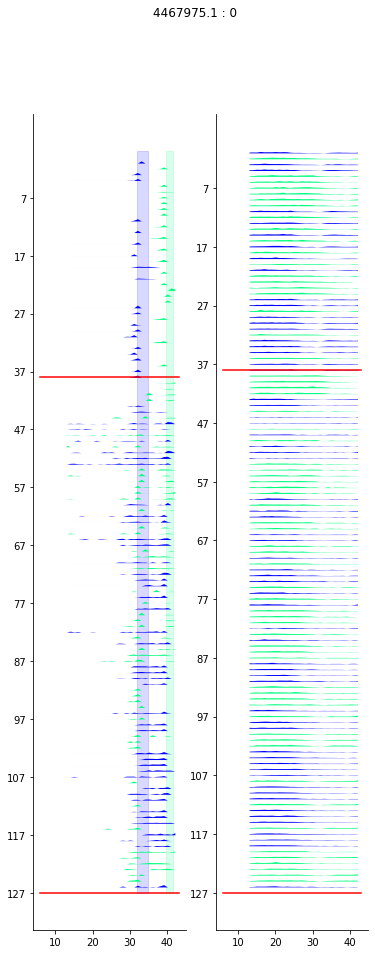

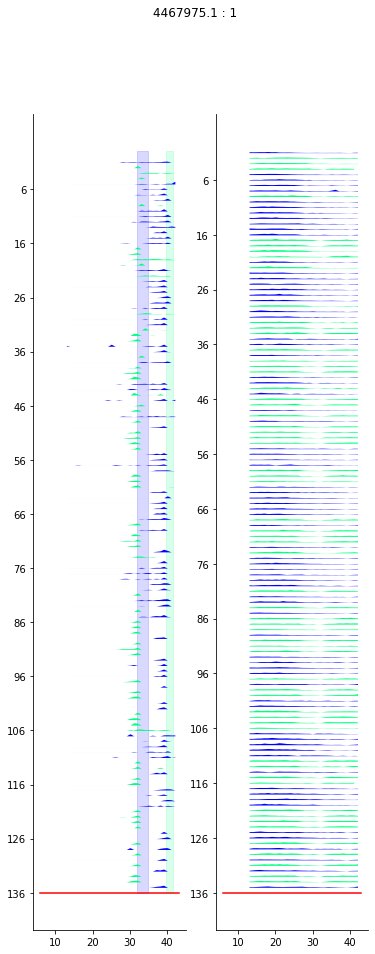

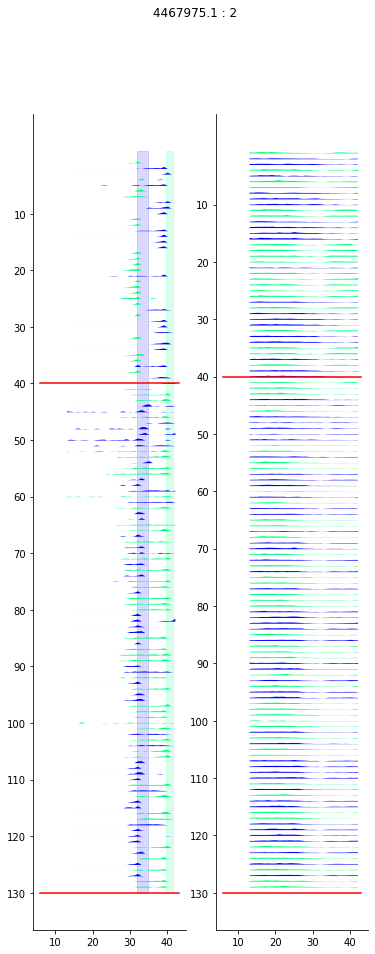

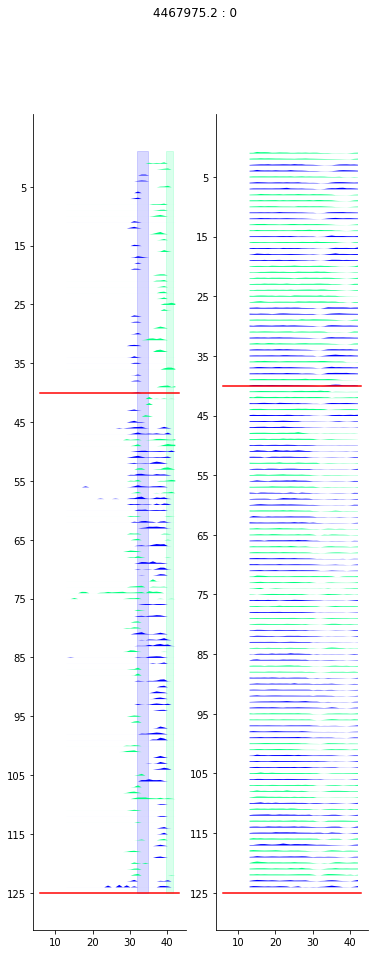

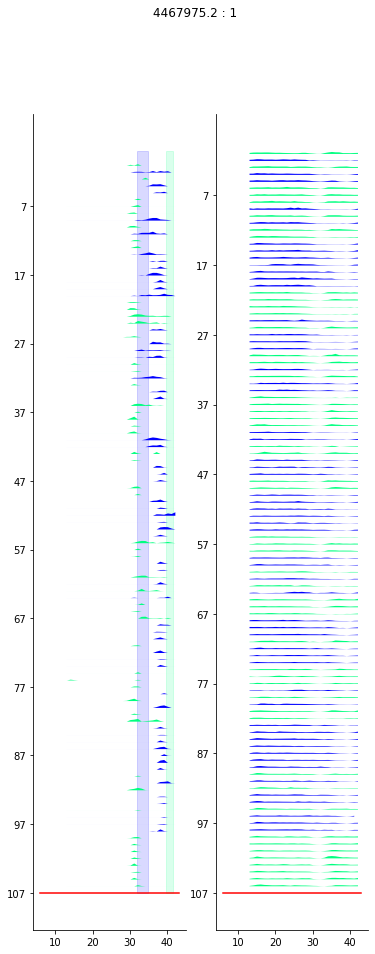

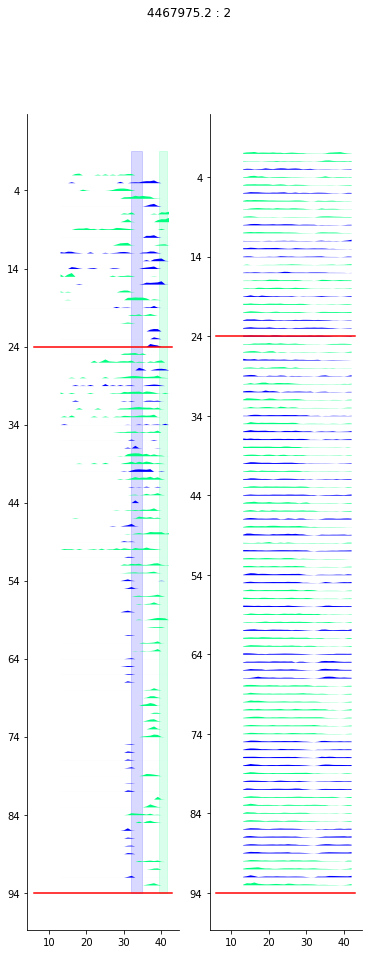

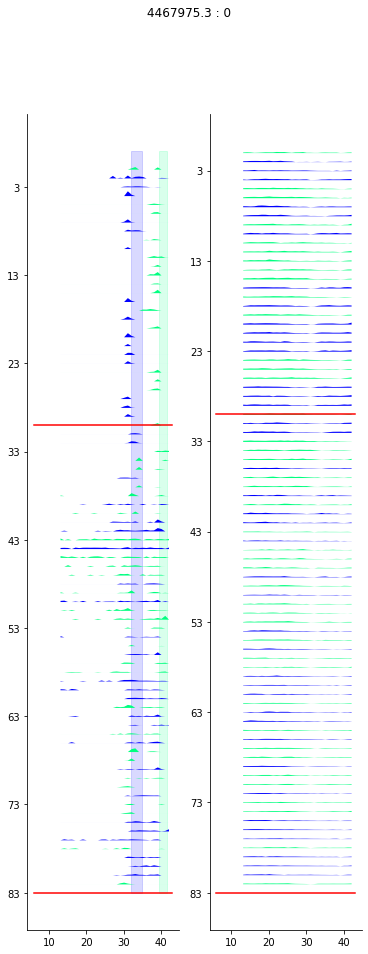

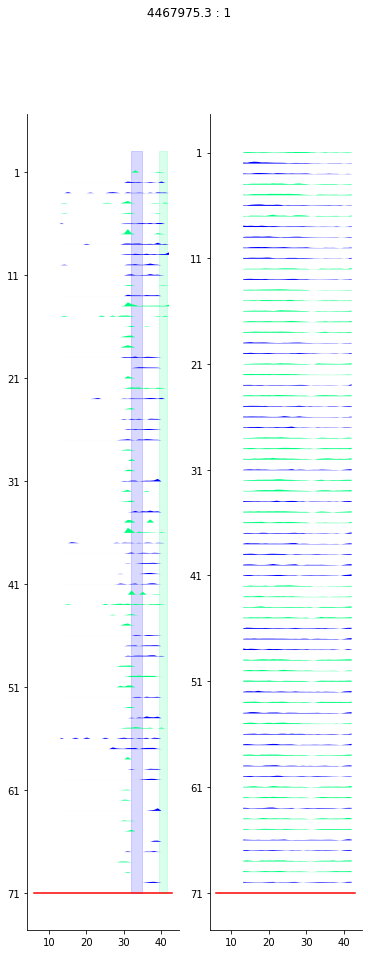

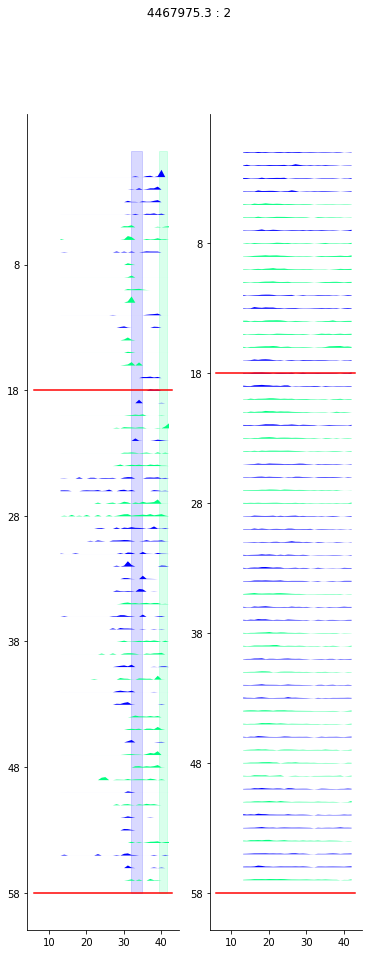

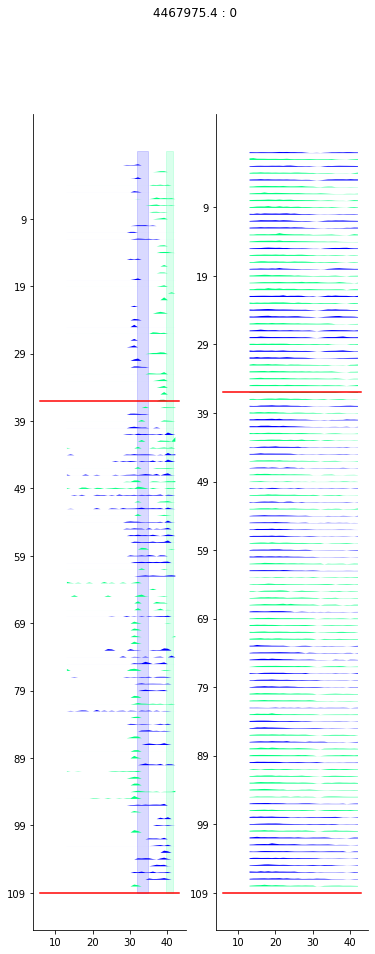

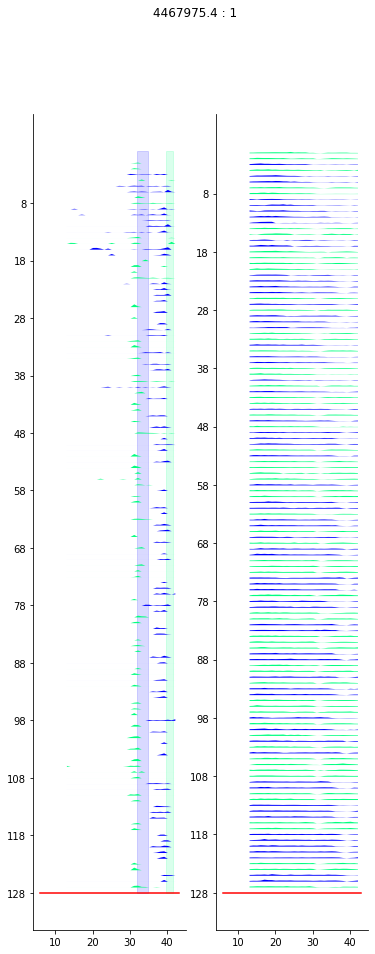

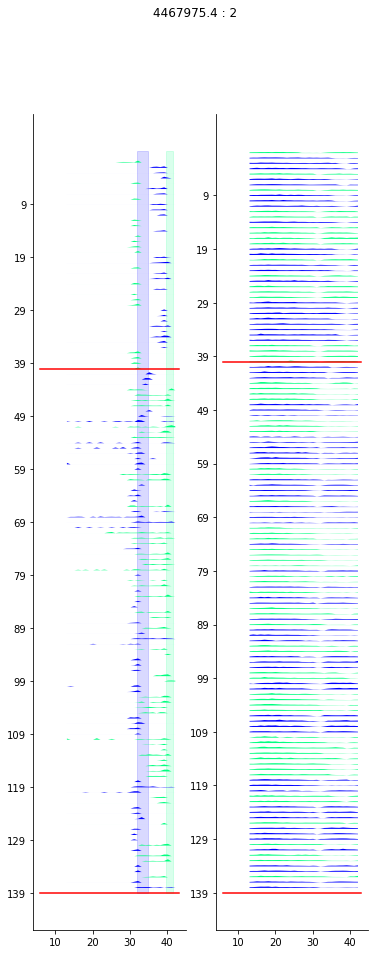

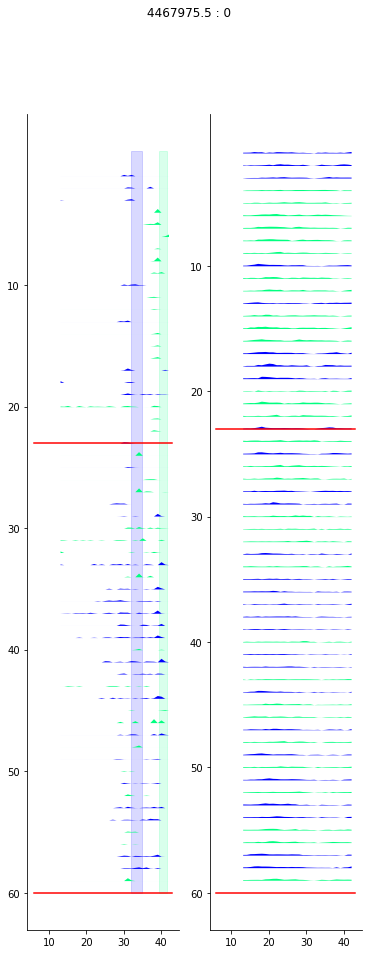

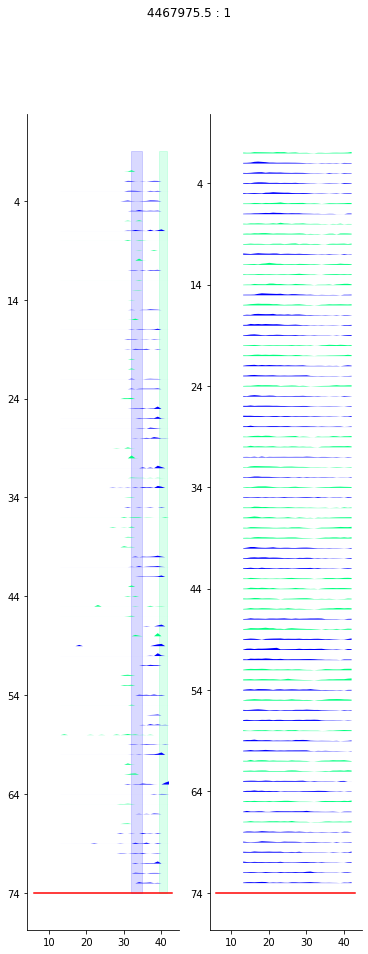

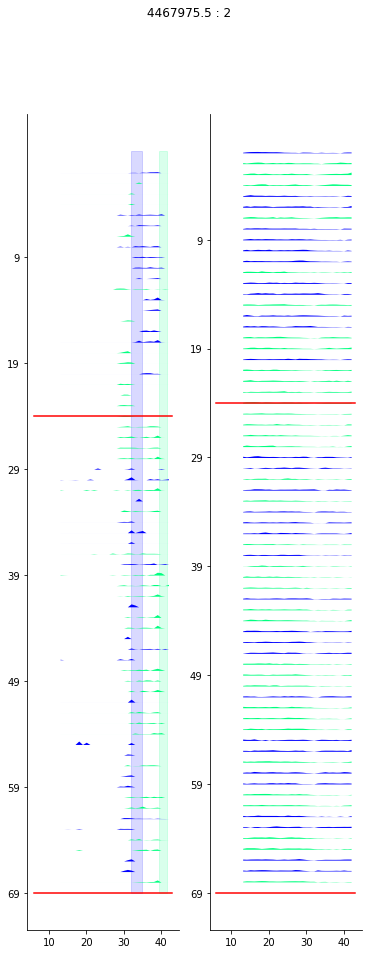

In [23]:
run_groupedsession_plots(KOs_reversals)
# !rclone copy {figdir_local} gdrive:{figdir_remote}

4467331.1
0 ({'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1}, {'date': '05_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1})
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
1 ({'date': '06_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 2},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
2 ({'date': '07_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1}, {'date': '07_12_2020', 'scene': 'YMaze_LNovel', 'session': 1})
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467331.2
0 ({'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1}, {'date': '05_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1})
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
1 ({'date': '06_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
2 ({'date': '07_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1}, {'date': '07_12_2020', 'scene': 'YMaze_LNovel', 'session': 1})
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467332.1
0 ({'date': '05_12_2020', 'scene': 'YMaze_LNovel', 'session': 1}, {'date': '05_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1})
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
1 ({'date': '06_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
2 ({'date': '07_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1}, {'date': '07_12_2020', 'scene': 'YMaze_LNovel', 'session': 1})
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467332.2
0 ({'date': '06_12_2020', 'scene': 'YMaze_LNovel', 'session': 1}, {'date': '06_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1})
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
1 ({'date': '06_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 2},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
2 ({'date': '07_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1}, {'date': '07_12_2020', 'scene': 'YMaze_LNovel', 'session': 1})
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467333.1
0 ({'date': '06_12_2020', 'scene': 'YMaze_LNovel', 'session': 1}, {'date': '06_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1})
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
1 ({'date': '07_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1},)


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
2 ({'date': '08_12_2020', 'scene': 'YMaze_RewardReversal', 'session': 1}, {'date': '08_12_2020', 'scene': 'YMaze_LNovel', 'session': 1})
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


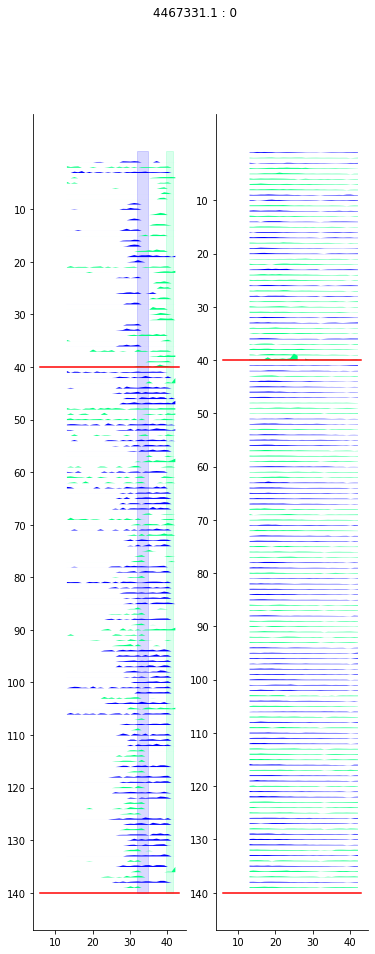

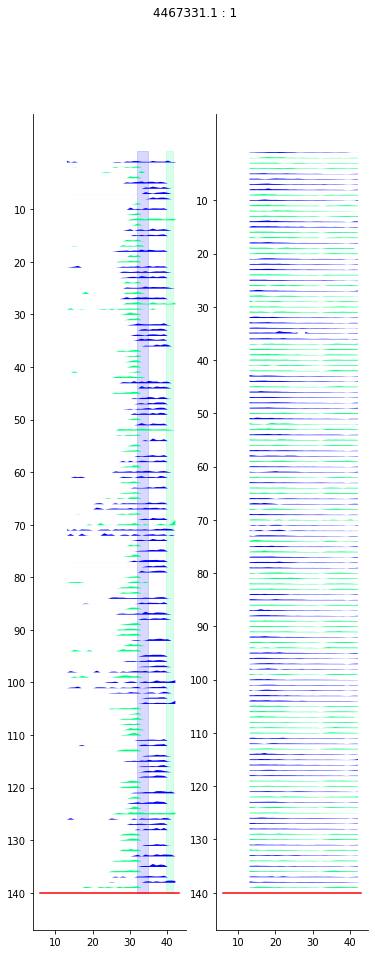

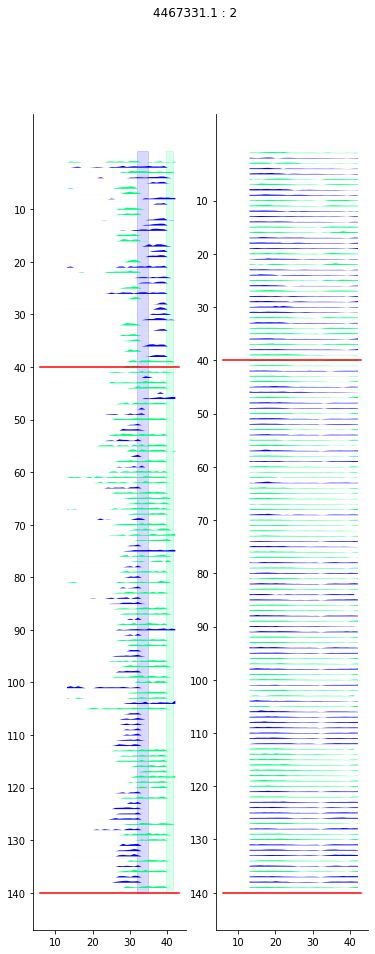

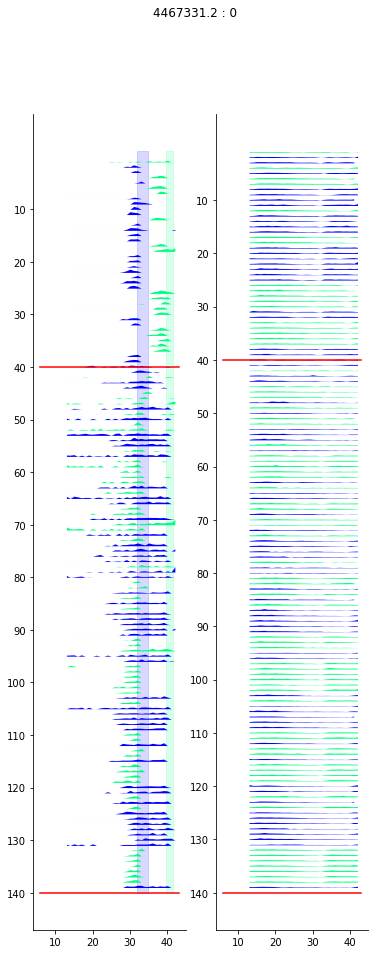

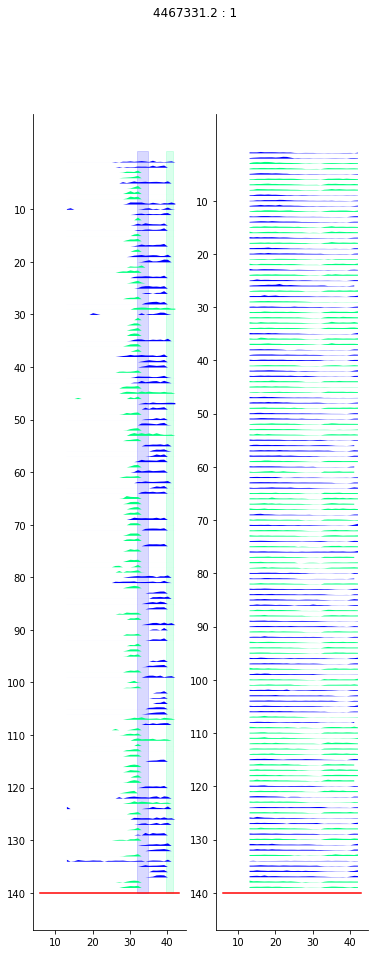

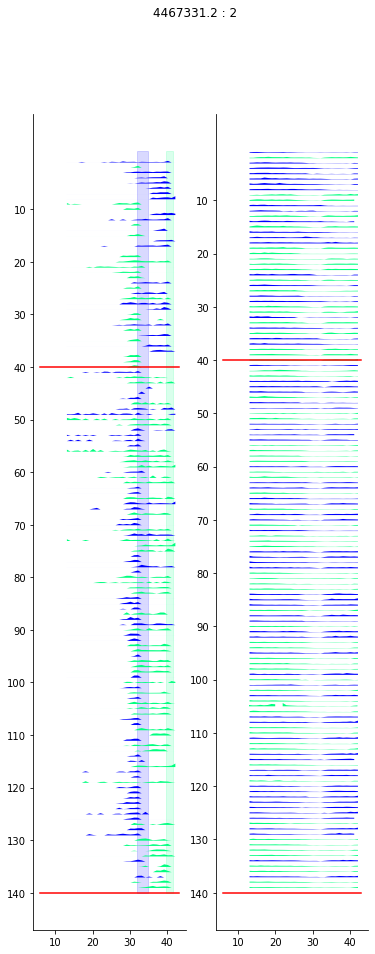

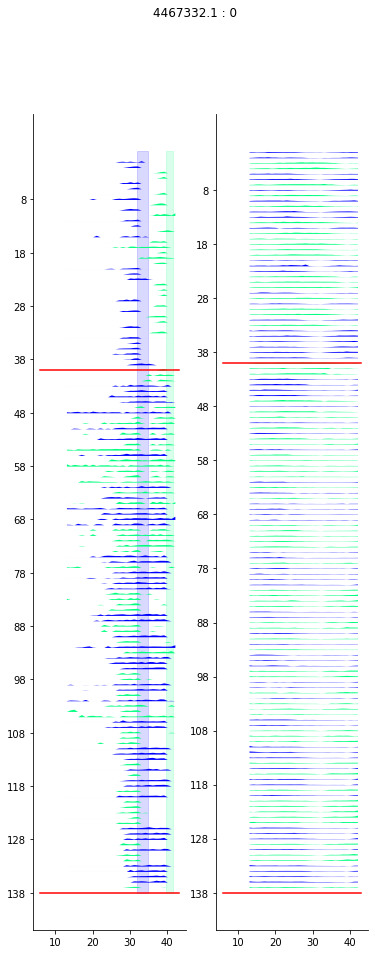

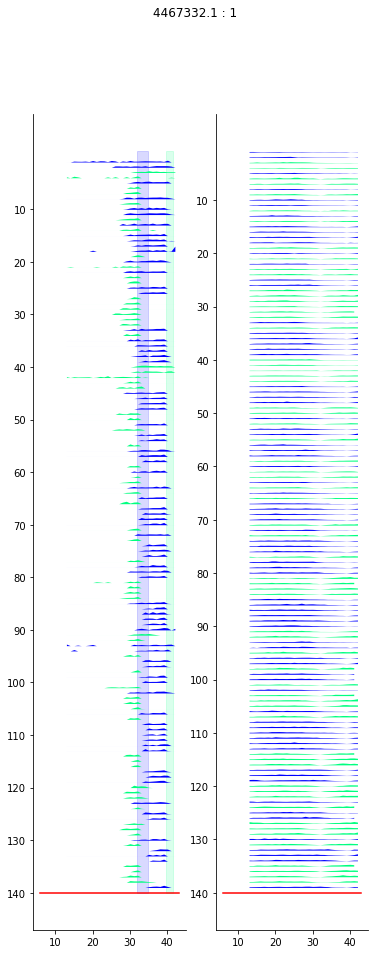

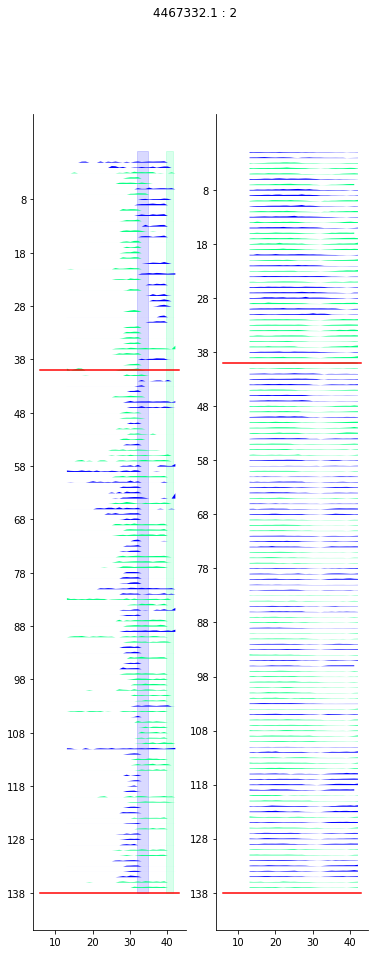

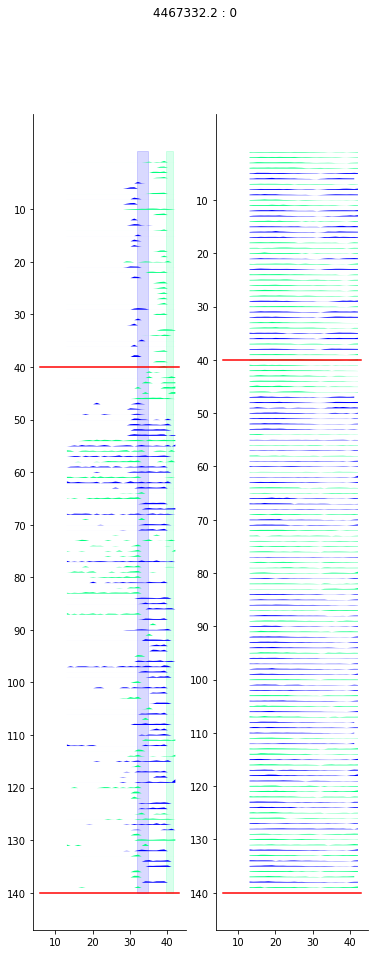

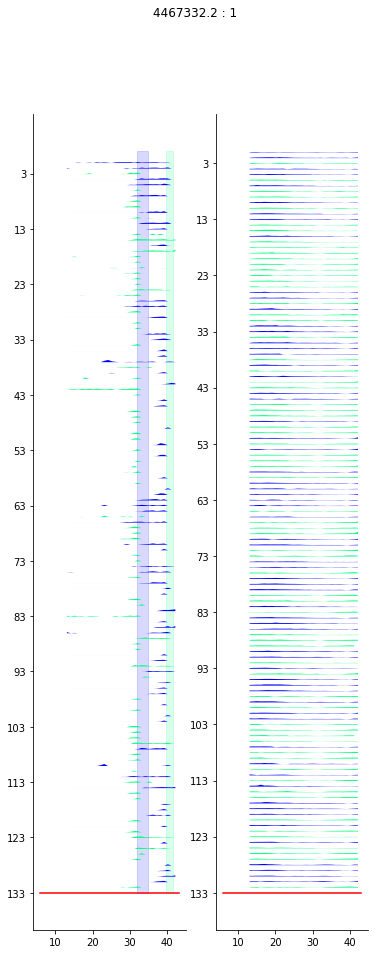

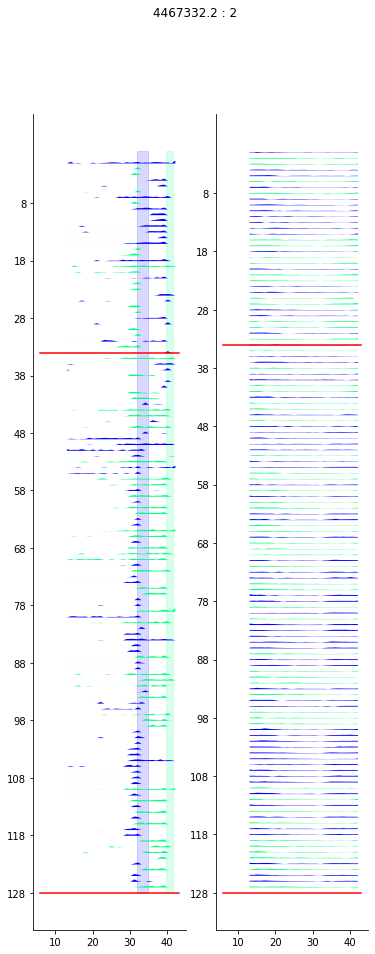

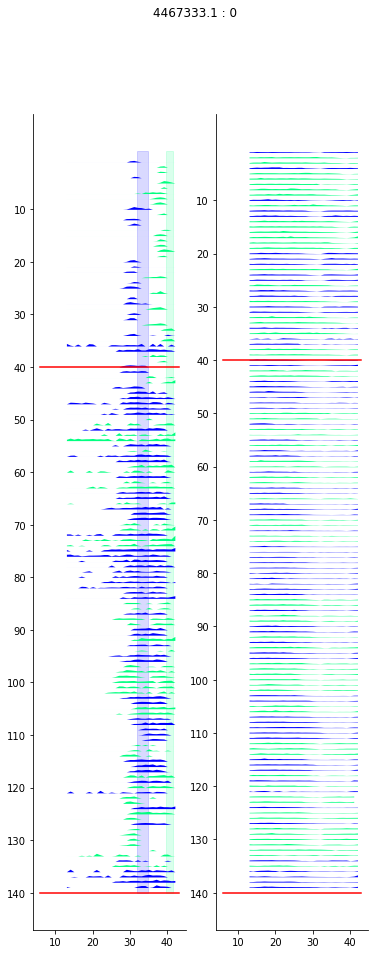

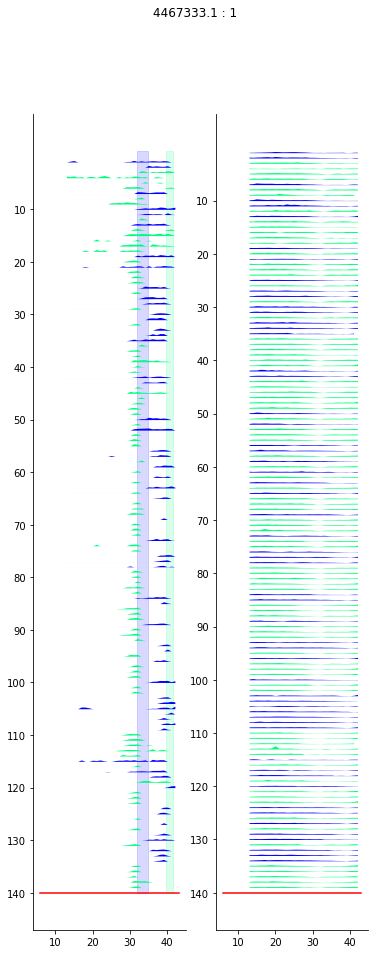

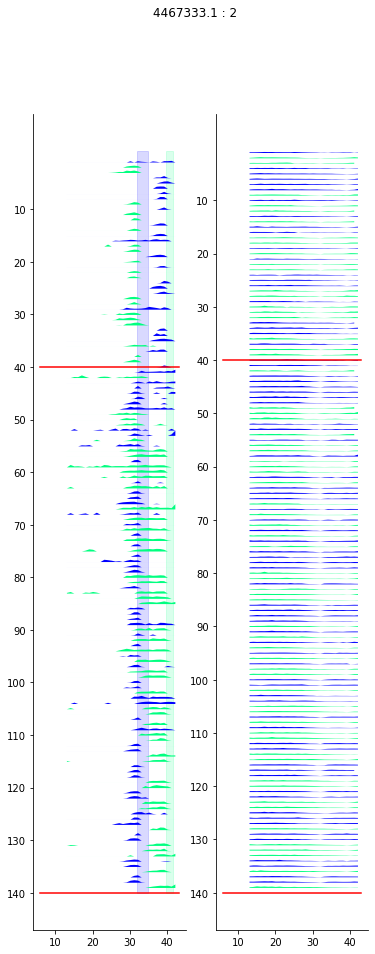

In [24]:
run_groupedsession_plots(CTRLs_reversals)
# !rclone copy {figdir_local} gdrive:{figdir_remote}

In [25]:

#19-29

def get_rzone_licking(SessDict):
    rzone_early = slice(25-6,32-6)
    rzone_late = slice(35-6,42-6)
    for mouse,days in SessDict.items():
    
#         day = days[-1]
        print(mouse)
    
        LR, LICKS, SPEED = [],[],[]
        transition_trials = []
        for day_ind, day in enumerate(days):
#             print(day_ind)
            for sess_ind,session in enumerate(day):
                sess = TwoPUtils.sess.Session(basedir_VR=basedir_VR,mouse = mouse, date = session['date'], scene= session['scene'], 
                                              session = session['session'], VR_only=True, prompt_for_keys=False )
                sess.align_VR_to_2P()

            #         print(np.amax(sess.vr_data['t']),np.amin(sess.vr_data['t']))

                # get block number for each trial
                block_number_trial, block_number_time = get_block_number(sess)

                # get LR value for each trial
                lr_trial = get_LR_trial(sess)

                # make position binned lick rates and speed
                sess.add_timeseries(licks=sess.vr_data['lick']._values,speed= sess.vr_data['dz']._values)
                sess.add_pos_binned_trial_matrix(('licks','speed'),'t',min_pos=6,max_pos=43,bin_size=1,mat_only=True)

                LR.append(lr_trial)
                LICKS.append(sess.trial_matrices['licks'])
                SPEED.append(sess.trial_matrices['speed'])
                
                
                transition_trials.append(lr_trial.shape[0])
#                 print(lr_trial.shape)
        LR, LICKS, SPEED = np.concatenate(LR,axis=0), np.concatenate(LICKS,axis=0),np.concatenate(SPEED,axis=0)
        transition_trials = np.cumsum(np.array(transition_trials)).tolist()
        print(transition_trials)
        
        print(rzone_early)
        
        licks_rz_early =LICKS[:,rzone_early].mean(axis=-1)
        licks_rz_late = LICKS[:,rzone_late].mean(axis=-1)
        f,ax = plt.subplots(1,2,figsize=[20,10])
        ax[0].scatter(np.arange(LR.shape[0])[LR==1],licks_rz_late[LR==1],color=plt.cm.winter(1.))
        ax[0].vlines(transition_trials,0,.3,color='red')
        ax[0].set_xlabel('trials')
        ax[0].set_ylabel('Lick rate')
        ax[0].set_title(mouse)
        
        ax[1].scatter(np.arange(LR.shape[0])[LR==-1],licks_rz_early[LR==-1],color=plt.cm.winter(0.))
        ax[1].vlines(transition_trials,0,.3,color='red')
        ax[1].set_xlabel('trials')
        ax[1].set_ylabel('Lick rate')
        ax[1].set_title(mouse)
        f.savefig(os.path.join(figdir_local,"RZoneEarlyLicks_%s.png" % mouse))
        

4467331.1
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
Fixing teleports
[40, 140, 280, 320, 420]
slice(19, 26, None)
4467331.2


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
Fixing teleports
[40, 140, 280, 320, 420]
slice(19, 26, None)
4467332.1


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
Fixing teleports
[40, 138, 278, 318, 416]
slice(19, 26, None)
4467332.2


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
Fixing teleports
[40, 140, 273, 307, 401]
slice(19, 26, None)
4467333.1


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
Fixing teleports
[40, 140, 280, 320, 420]
slice(19, 26, None)


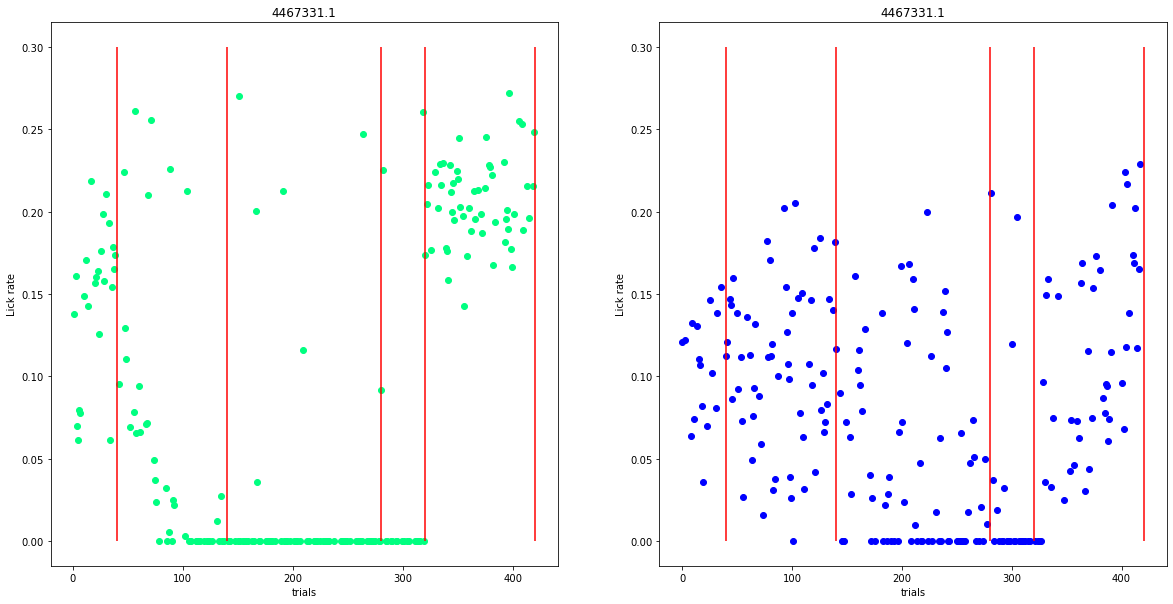

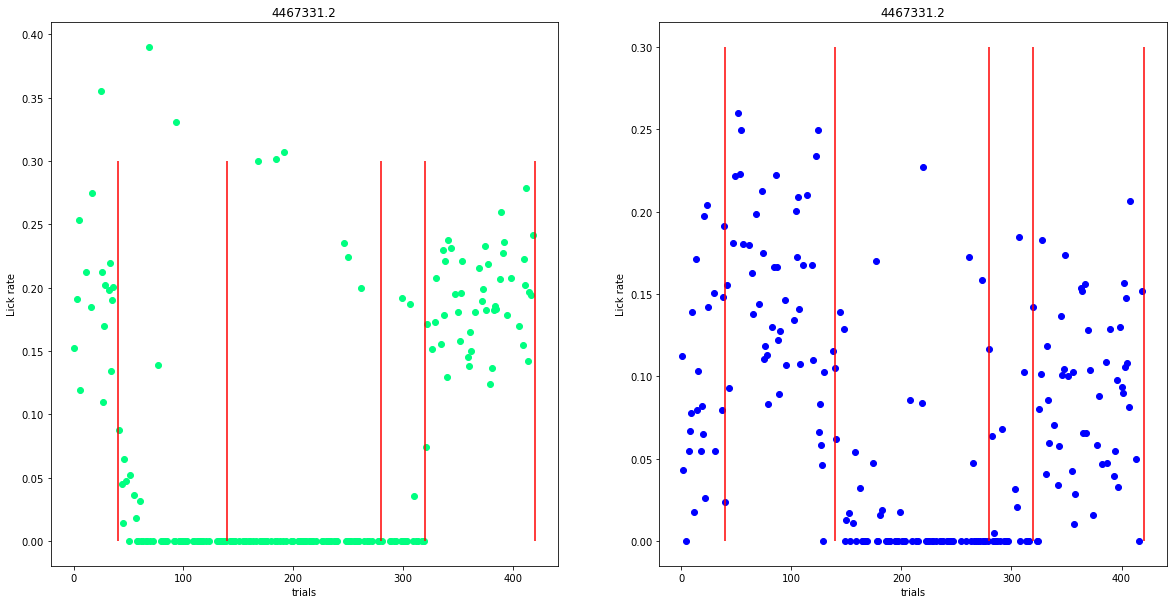

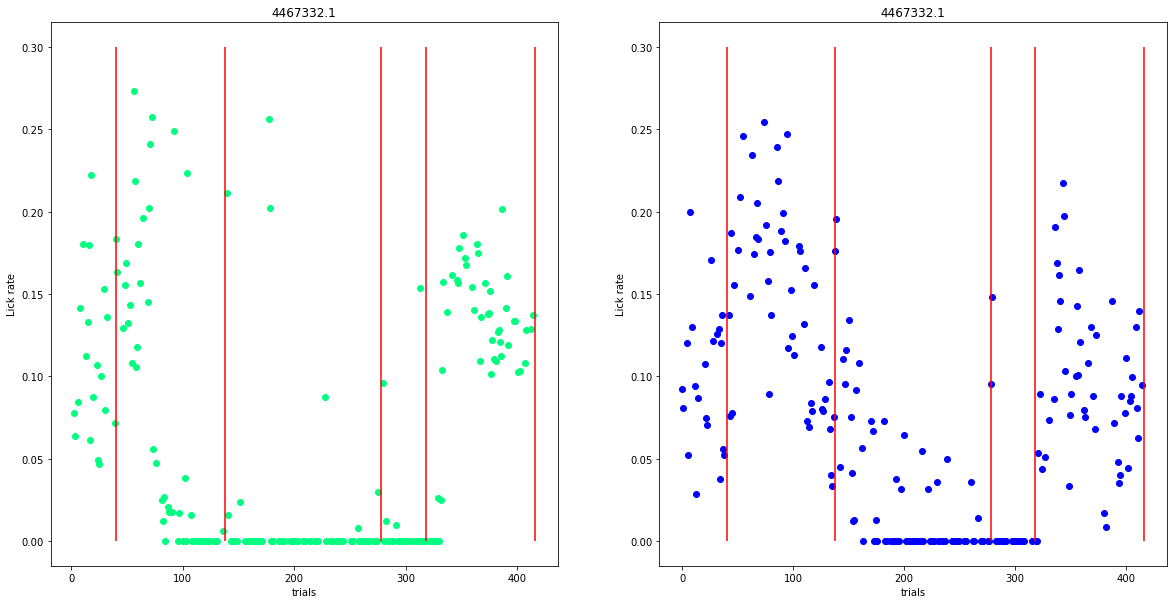

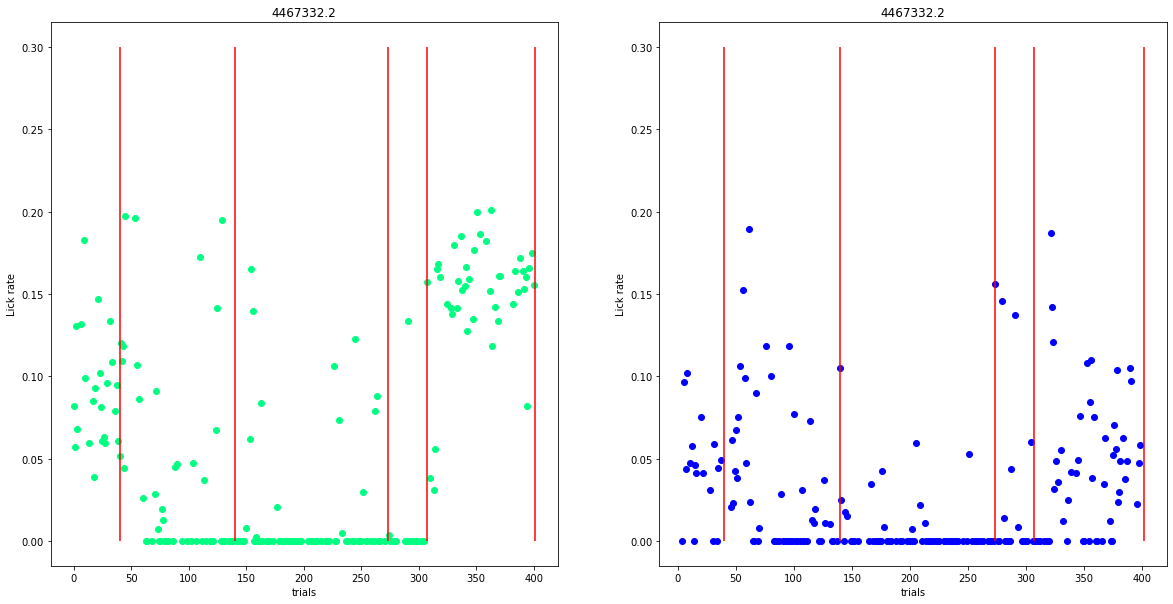

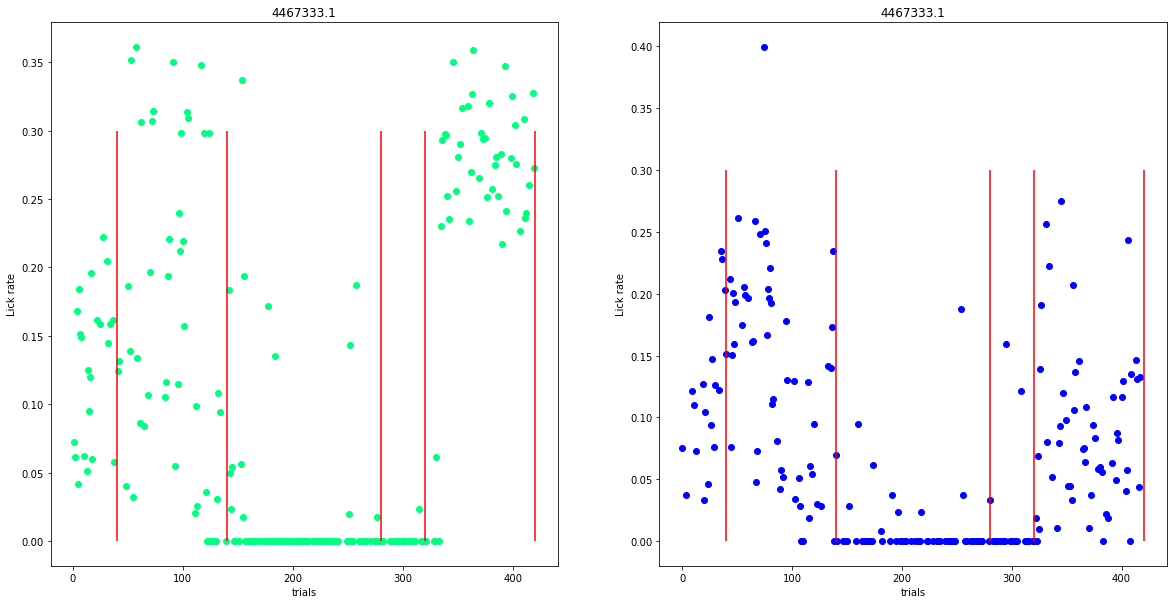

In [26]:
get_rzone_licking(CTRLs_reversals)

4467975.1
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
Fixing teleports
[38, 127, 263, 303, 393]
slice(19, 26, None)
4467975.2


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
Fixing teleports
[40, 125, 232, 256, 326]
slice(19, 26, None)
4467975.3
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
Fixing teleports
[30, 83, 154, 172, 212]
slice(19, 26, None)
4467975.4
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
Fixing teleports
[36, 109, 237, 277, 376]
slice(19, 26, None)
4467975.5


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
Fixing teleports
[23, 60, 134, 158, 203]
slice(19, 26, None)


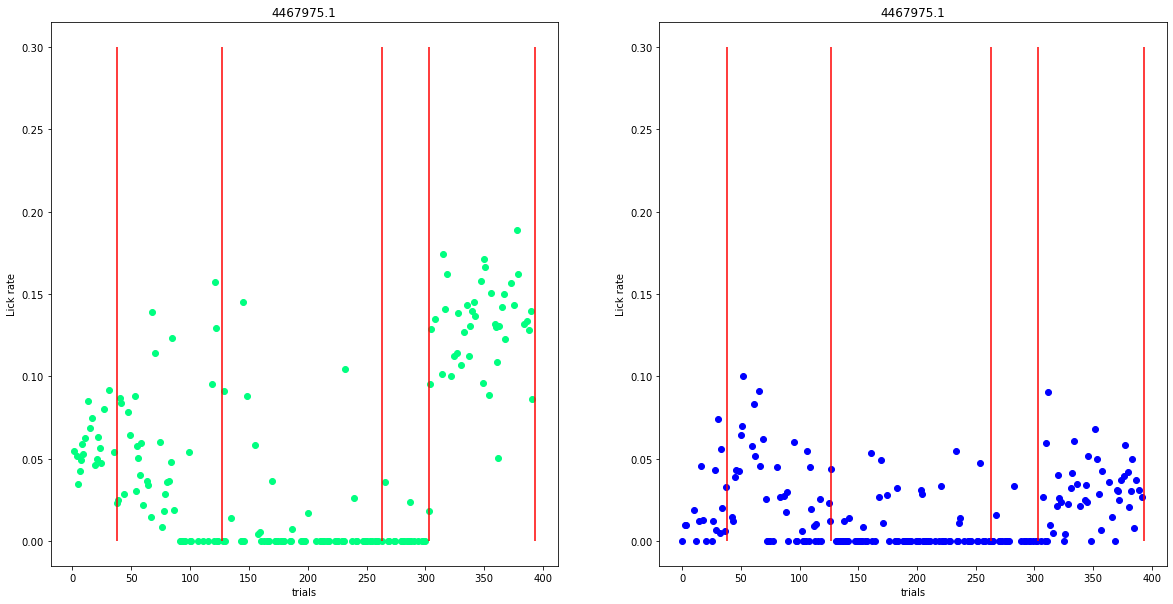

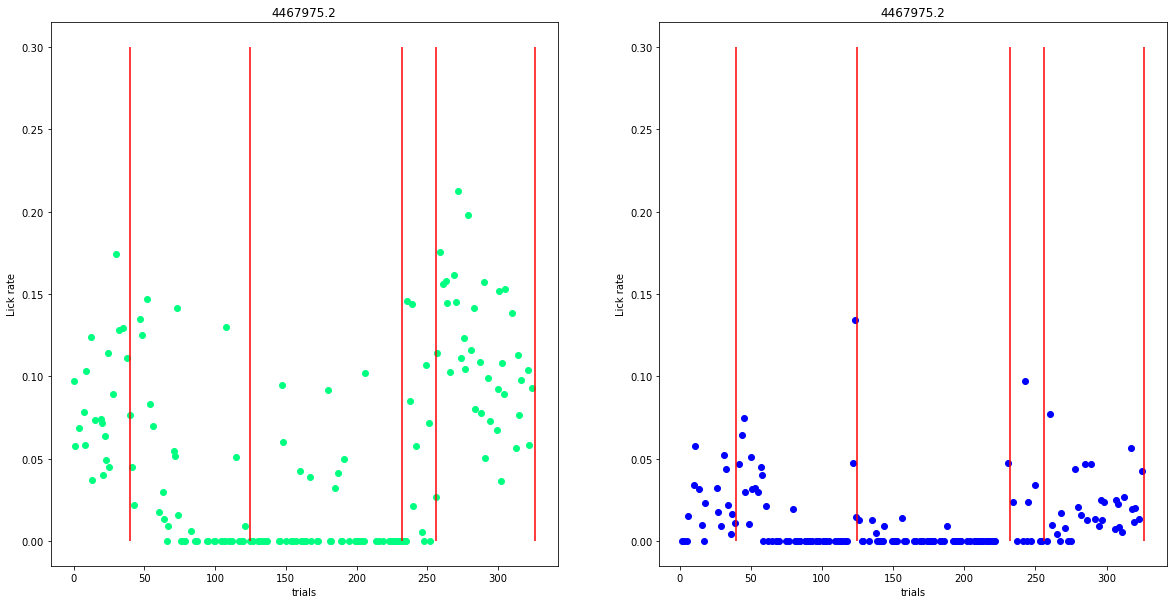

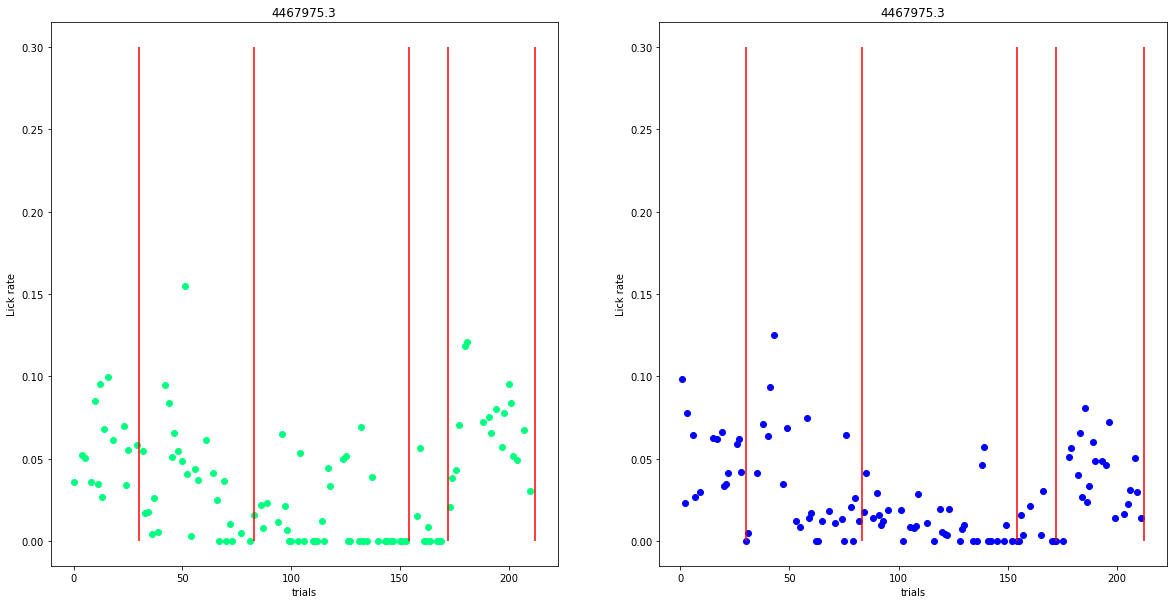

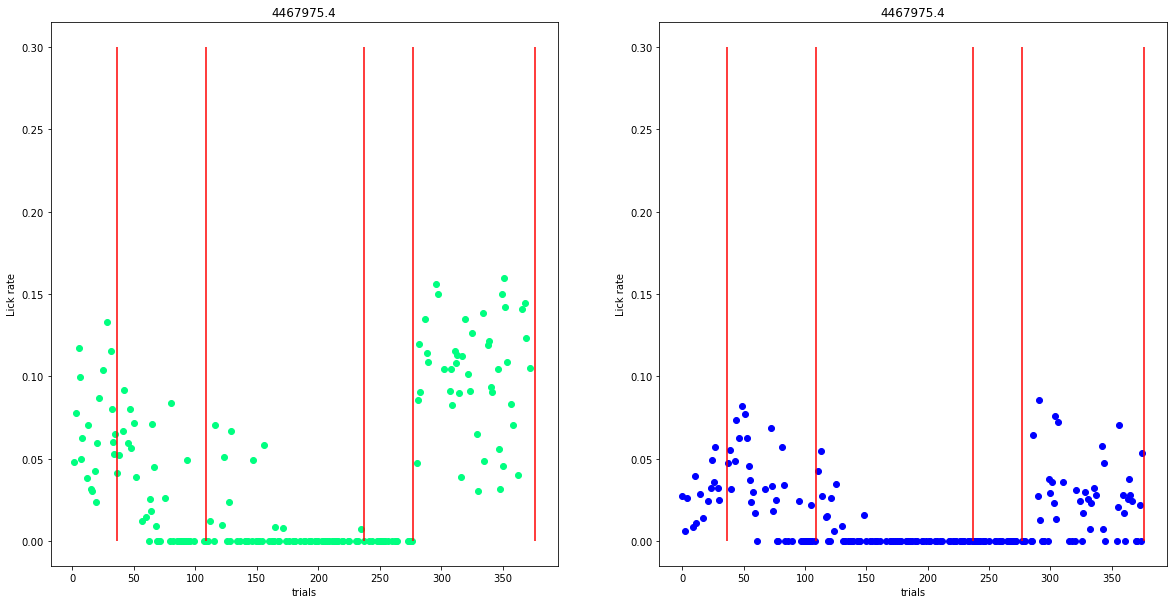

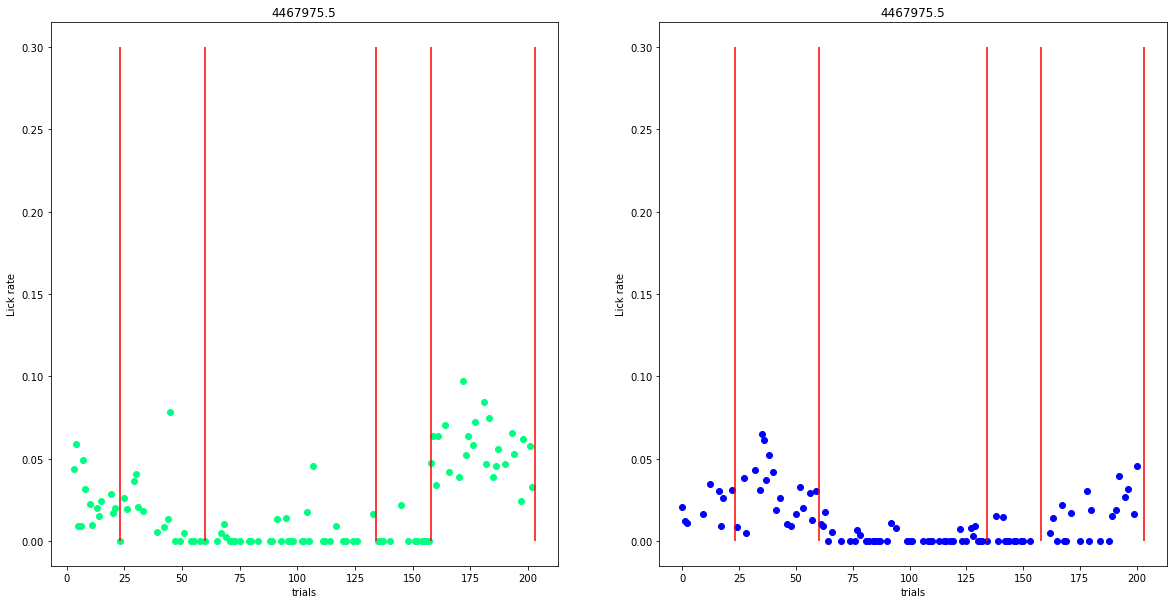

In [27]:
get_rzone_licking(KOs_reversals)

In [ ]:
!rclone copy {figdir_local} gdrive:{figdir_remote}

In [29]:
# lickrate divided by baseline pre switch over trials
# 


# look at late zone licking too
def first_reversal(SessDict):
    rzone_early = slice(25-6,32-6)
    rzone_late = slice(35-6,42-6)
    RZONE_LICKS = {}
    slopes = np.zeros([len(SessDict.keys()),])
    for m,(mouse,days) in enumerate(SessDict.items()):
        print(mouse)    
        LR, LICKS, SPEED = [],[],[]
        transition_trials = []
        early_rzone_licks = []
        for i, day in enumerate(days[:2]):
                  
            for sess_ind,session in enumerate(day):
                sess = TwoPUtils.sess.Session(basedir_VR=basedir_VR,mouse = mouse, date = session['date'], scene= session['scene'], 
                                              session = session['session'], VR_only=True, prompt_for_keys=False )
                sess.align_VR_to_2P()

                # get LR value for each trial
                lr_trial = get_LR_trial(sess)

                # make position binned lick rates and speed
                sess.add_timeseries(licks=sess.vr_data['lick']._values,speed= sess.vr_data['dz']._values)
                sess.add_pos_binned_trial_matrix(('licks','speed'),'t',min_pos=6,max_pos=43,bin_size=1,mat_only=True)

                licks_rz_early =sess.trial_matrices['licks'][:,rzone_early].mean(axis=-1)

                if i==0 and sess_ind ==0:
                    baseline = np.mean(licks_rz_early[lr_trial==-1])
                else:
                    licks = licks_rz_early[lr_trial==-1]/baseline
                    licks[np.isnan(licks)]= 0
                    early_rzone_licks.append(licks)
        
                
#         f, ax = plt.subplots()
        early_rzone_licks = np.concatenate(early_rzone_licks)
        lr = hubreg().fit(np.arange(30)[:,np.newaxis],early_rzone_licks[:30])
        slopes[m] = lr.coef_
#         ax.plot(early_rzone_licks)
        
#         ax.plot(sp.ndimage.filters.gaussian_filter1d(early_rzone_licks,5))
            
        RZONE_LICKS[mouse] = early_rzone_licks
    return RZONE_LICKS, slopes
    # fit a spline to the data
    
    # average across mice and compare groups
    
    
    # do the same thing but for 
    # first reversal 
    
    # second reversal
    
    

In [30]:
ctrl_licks, ctrl_slopes = first_reversal(CTRLs_reversals)
ko_licks, ko_slopes = first_reversal(KOs_reversals)

4467331.1
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467331.2
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467332.1
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467332.2
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467333.1
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467975.1
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467975.2
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467975.3
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467975.4


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467975.5
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


3.12470645699167 0.014127827696005516


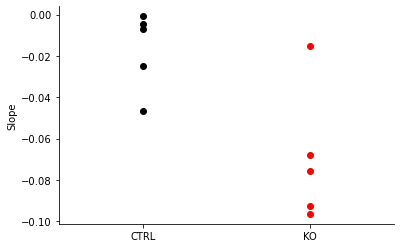

In [31]:
f,ax = plt.subplots()
ax.scatter(np.zeros([5,]),ctrl_slopes,color='black')
ax.scatter(np.ones([5,]),ko_slopes,color='red')
ax.set_xlim([-.5,1.5])
ax.set_xticks([0,1])
ax.set_xticklabels(['CTRL','KO'])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Slope')
s,p = sp.stats.ttest_ind(ctrl_slopes,ko_slopes)
f.savefig(os.path.join(figdir_local,"RZoneLickSlope.pdf" ))
print(s,p)

In [32]:
ctrl_licks_arr = np.zeros([5,150])
ctrl_licks_arr[:]=np.nan
for i,(m,licks) in enumerate(ctrl_licks.items()):
    ctrl_licks_arr[i,:licks.size]=licks
    
ko_licks_arr = np.zeros([5,150])
ko_licks_arr[:]=np.nan
for i,(m,licks) in enumerate(ko_licks.items()):
    ko_licks_arr[i,:licks.size]=licks

/home/mplitt/anaconda3/envs/STX3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/home/mplitt/anaconda3/envs/STX3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


0.016293603621028527 0.001
0.016293603621028527
(130,)
(118,)
(125,)
(117,)
(111,)
(119,)
(103,)
(60,)
(104,)
(60,)


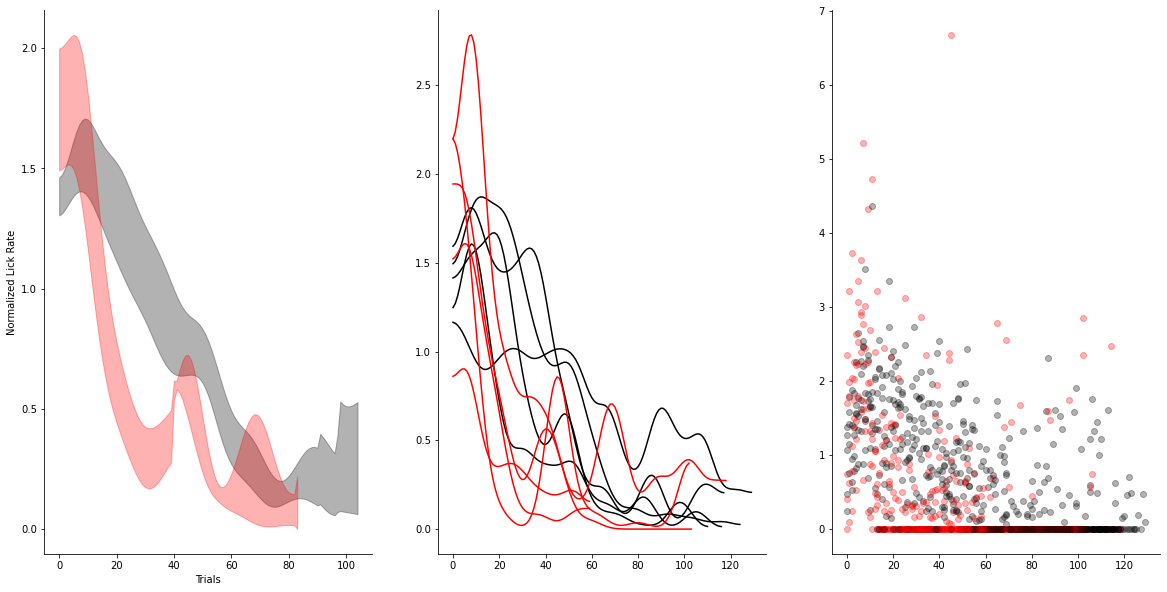

In [33]:


f,ax = plt.subplots(1,3,figsize=[20,10])
ctrl_licks_sm = sp.ndimage.gaussian_filter1d(ctrl_licks_arr,5,axis=-1)
mu,sem = np.nanmean(ctrl_licks_sm,axis=0), sp.stats.sem(ctrl_licks_sm,axis=0,nan_policy='omit')
trials = np.arange(150)
ax[0].fill_between(trials,mu-sem,y2=mu+sem,color='black',alpha=.3)

ko_licks_sm = sp.ndimage.gaussian_filter1d(ko_licks_arr,5,axis=-1)
mu,sem = np.nanmean(ko_licks_sm,axis=0), sp.stats.sem(ko_licks_sm,axis=0,nan_policy='omit')
ax[0].fill_between(trials,mu-sem,y2=mu+sem,color='red',alpha=.3)

stat,p = np.zeros([50,]),np.zeros([50,])
for c in range(50):
    _stat,_p = sp.stats.ranksums(ctrl_licks_sm[:,c],ko_licks_sm[:,c])
#     print(_stat,_p)
    stat[c],p[c]=_stat,_p
    
p_sort = np.sort(p)
i = 1
print(p_sort[i-1],i/float(p_sort.shape[0])*.05)
while p_sort[i-1]<=float(i)/p_sort.shape[0]*.05 and i<p_sort_shape:
    i+=1
    
p_thresh = p_sort[i]
print(p_thresh)

_trials = np.arange(50)
_stars = np.ones(_trials.shape)+1
# ax[0].scatter(_trials[p<=p_thresh],_stars[p<=p_thresh],marker='x',color='blue')

ax[0].set_ylabel('Normalized Lick Rate')
ax[0].set_xlabel('Trials')

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)


for m,licks in ctrl_licks.items():
    print(licks.shape)
    ax[1].plot(sp.ndimage.filters.gaussian_filter1d(licks,5),color='black')
    
for m,licks in ko_licks.items():
    print(licks.shape)
    ax[1].plot(sp.ndimage.filters.gaussian_filter1d(licks,5),color='red')


ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[0].set_ylabel('Normalized Lick Rate')
ax[0].set_xlabel('Trials')

for i in range(5):
    ax[2].scatter(np.arange(ctrl_licks_arr.shape[1]),ctrl_licks_arr[i,:],color='black',alpha=.3)
    ax[2].scatter(np.arange(ko_licks_arr.shape[1]),ko_licks_arr[i,:],color='red',alpha=.3)
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)


f.savefig(os.path.join(figdir_local,"RZoneEarlyLicks_v_trials.pdf" ))

In [34]:
# lickrate divided by baseline pre switch over trials
def second_reversal(SessDict):
    
    rzone_early = slice(25-6,32-6)
    RZONE_LICKS = {}
    for m,(mouse,days) in enumerate(SessDict.items()):
        print(mouse)    
        LR, LICKS, SPEED = [],[],[]
        transition_trials = []
        early_rzone_licks = []
        day = days[-1]
                  
        for sess_ind,session in enumerate(day):
            sess = TwoPUtils.sess.Session(basedir_VR=basedir_VR,mouse = mouse, date = session['date'], scene= session['scene'], 
                                          session = session['session'], VR_only=True, prompt_for_keys=False )
            sess.align_VR_to_2P()

            # get LR value for each trial
            lr_trial = get_LR_trial(sess)

            # make position binned lick rates and speed
            sess.add_timeseries(licks=sess.vr_data['lick']._values,speed= sess.vr_data['dz']._values)
            sess.add_pos_binned_trial_matrix(('licks','speed'),'t',min_pos=6,max_pos=43,bin_size=1,mat_only=True)

            licks_rz_early =sess.trial_matrices['licks'][:,rzone_early].mean(axis=-1)

            if sess_ind ==0:
                baseline = np.mean(licks_rz_early[lr_trial==1])
            else:
                licks = licks_rz_early[lr_trial==1]/baseline
                licks[np.isnan(licks)]= 0
                early_rzone_licks.append(licks)
                
            
        RZONE_LICKS[mouse] = np.concatenate(early_rzone_licks)
    return RZONE_LICKS

In [35]:
ctrl_licks = second_reversal(CTRLs_reversals)
ko_licks = second_reversal(KOs_reversals)

4467331.1
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467331.2
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467332.1
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467332.2
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467333.1
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467975.1
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467975.2
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
4467975.3


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
Fixing teleports
4467975.4


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports
Fixing teleports
4467975.5
Fixing teleports


/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")
/home/mplitt/repos/TwoPUtils/TwoPUtils/sess.py:93: UserWarning: skipping checking keys, remaining initialization not guaranteed to work
  warnings.warn("skipping checking keys, remaining initialization not guaranteed to work")


Fixing teleports


0.009023438818080326
(54,)
(48,)
(48,)
(42,)
(46,)
(43,)
(38,)
(18,)
(46,)
(25,)


/home/mplitt/anaconda3/envs/STX3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Mean of empty slice
  
/home/mplitt/anaconda3/envs/STX3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice


Text(0.5, 0, 'Trials')

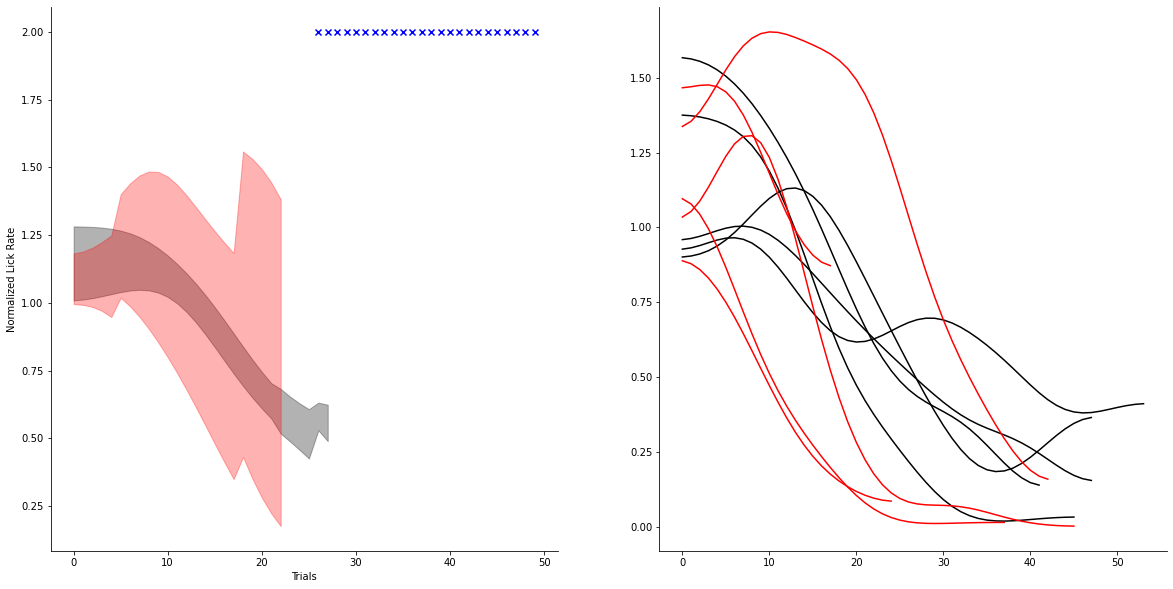

In [36]:
ctrl_licks_arr = np.zeros([5,150])
ctrl_licks_arr[:]=np.nan
for i,(m,licks) in enumerate(ctrl_licks.items()):
    ctrl_licks_arr[i,:licks.size]=licks
    
ko_licks_arr = np.zeros([5,150])
ko_licks_arr[:]=np.nan
for i,(m,licks) in enumerate(ko_licks.items()):
    ko_licks_arr[i,:licks.size]=licks
    

f,ax = plt.subplots(1,2,figsize=[20,10])
ctrl_licks_sm = sp.ndimage.gaussian_filter1d(ctrl_licks_arr,5,axis=-1)
mu,sem = np.nanmean(ctrl_licks_sm,axis=0), sp.stats.sem(ctrl_licks_sm,axis=0,nan_policy='omit')
trials = np.arange(150)
ax[0].fill_between(trials,mu-sem,y2=mu+sem,color='black',alpha=.3)

ko_licks_sm = sp.ndimage.gaussian_filter1d(ko_licks_arr,5,axis=-1)
mu,sem = np.nanmean(ko_licks_sm,axis=0), sp.stats.sem(ko_licks_sm,axis=0,nan_policy='omit')
ax[0].fill_between(trials,mu-sem,y2=mu+sem,color='red',alpha=.3)

stat,p = np.zeros([50,]),np.zeros([50,])
for c in range(50):
    _stat,_p = sp.stats.ranksums(ctrl_licks_sm[:,c],ko_licks_sm[:,c])
#     print(_stat,_p)
    stat[c],p[c]=_stat,_p
    
p_sort = np.sort(p)
i = 0
while p_sort[i]<=i/p_sort.shape[0]*.05 and i<p_sort_shape:
    i+=1
    
p_thresh = p_sort[i]
print(p_thresh)

_trials = np.arange(50)
_stars = np.ones(_trials.shape)+1
ax[0].scatter(_trials[p<=p_thresh],_stars[p<=p_thresh],marker='x',color='blue')

ax[0].set_ylabel('Normalized Lick Rate')
ax[0].set_xlabel('Trials')

ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)


for m,licks in ctrl_licks.items():
    print(licks.shape)
    ax[1].plot(sp.ndimage.filters.gaussian_filter1d(licks,5),color='black')
    
for m,licks in ko_licks.items():
    print(licks.shape)
    ax[1].plot(sp.ndimage.filters.gaussian_filter1d(licks,5),color='red')

    
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[0].set_ylabel('Normalized Lick Rate')
ax[0].set_xlabel('Trials')
